In [1]:
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
# ensemble learning
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
# metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as ss
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve


Introduction

The malware industry has developed into a well-resourced, high-value market in recent years. Multiplayer syndicates that are well-funded make significant investments in technologies and tools designed to circumvent conventional security, necessitating the development of countermeasures by anti-malware companies to identify and disable them. They cause actual financial and emotional harm to computer system users in the interim. The enormous amounts of data and files that need to be examined for any malicious intent provide one of the biggest issues anti-malware programs now face.
We must be able to divide them into groups and recognize their various families in order to analyze and categorize such massive volumes of material effectively. Additionally, these grouping criteria may be used to identify new files that are discovered on computers as dangerous and belonging to a specific family. Microsoft is supporting open-source development of efficient methods for classifying variant malware files into their respective families while also giving the data science community access to a previously unheard-of malware dataset and based on this data, I developed this project.

Loading data

In [2]:
df = pd.read_csv('data.csv')


Dataset analysis

The target variable represents a mix of 9 different malware file families. Each malware file has an ID:
1.	Ramnit
2.	Lizak
3.	Kelihos_ver3
4.	Vundo
5.	Simda
6.	Tracur
7.	Kelihos_ver1
8.	Obfuscator.ACY
9.	Gatak


The explanatory variables contain the hexadecimal representation of the binary contents of the file which is a log containing various metadata information extracted from the binary, such as function calls, strings, etc. This was generated using the IDA disassembler tool and used on this one hot encoded.


I'm doing a general data check. I check how many records I have, and how many variables I have. What type of variables predominate, or continuous or integer variables.

In [3]:
df

asm_commands_add  asm_commands_call  asm_commands_cdq  \
0                   436              646.0               0.0   
1                   469              262.0               0.0   
2                  1587             1828.0               0.0   
3                   213              227.0               0.0   
4                    36               76.0               0.0   
...                 ...                ...               ...   
10863               235               98.0              36.0   
10864                60               43.0               0.0   
10865               277              151.0               1.0   
10866               101               45.0               0.0   
10867               267              134.0               1.0   

       asm_commands_cld  asm_commands_cli  asm_commands_cmc  asm_commands_cmp  \
0                  10.0               9.0               0.0             228.0   
1                   4.0               1.0               4.0             185.0   
2                   0.0              31.0               0.0             689.0   
3                   0.0               3.0               0.0             127.0   
4                   0.0               0.0               0.0              15.0   
...                 ...               ...               ...               ...   
10863              26.0               0.0              22.0             155.0   
10864               0.0               9.0               0.0               1.0   
10865               8.0              11.0               1.0              58.0   
10866              16.0               1.0               0.0              31.0   
10867              14.0               6.0               1.0              44.0   

       asm_commands_cwd  asm_commands_daa  asm_commands_dd  ...  \
0                   0.0              56.0            89930  ...   
1                   4.0              20.0             3464  ...   
2                   0.0             904.0            24833  ...   
3                   0.0             132.0            71979  ...   
4                   0.0               0.0              112  ...   
...                 ...               ...              ...  ...   
10863              28.0              56.0             1768  ...   
10864               0.0              39.0             2003  ...   
10865               2.0             128.0             6319  ...   
10866              16.0               3.0              708  ...   
10867               3.0             127.0             6320  ...   

       asm_commands_sti  asm_commands_stos  asm_commands_sub  \
0                   1.0                0.0             892.0   
1                   3.0                7.0             846.0   
2                   1.0                0.0            4005.0   
3                   0.0                0.0             437.0   
4                   2.0                3.0              82.0   
...                 ...                ...               ...   
10863              33.0               37.0             368.0   
10864               0.0                0.0               0.0   
10865               0.0               18.0             463.0   
10866               0.0                1.0             111.0   
10867               0.0               17.0             368.0   

       asm_commands_test  asm_commands_wait  asm_commands_xchg  \
0                   53.0               10.0                0.0   
1                    8.0                0.0                9.0   
2                  680.0               44.0                0.0   
3                   78.0                0.0                0.0   
4                   16.0                0.0                0.0   
...                  ...                ...                ...   
10863               36.0                9.0               67.0   
10864                0.0                0.0                0.0   
10865               30.0               16.0               34.0   
10866               13.0       

In [4]:
df.shape

(10868, 69)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 69 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asm_commands_add    10868 non-null  int64  
 1   asm_commands_call   10868 non-null  float64
 2   asm_commands_cdq    10868 non-null  float64
 3   asm_commands_cld    10868 non-null  float64
 4   asm_commands_cli    10868 non-null  float64
 5   asm_commands_cmc    10868 non-null  float64
 6   asm_commands_cmp    10868 non-null  float64
 7   asm_commands_cwd    10868 non-null  float64
 8   asm_commands_daa    10868 non-null  float64
 9   asm_commands_dd     10868 non-null  int64  
 10  asm_commands_dec    10868 non-null  float64
 11  asm_commands_dw     10868 non-null  float64
 12  asm_commands_endp   10868 non-null  float64
 13  asm_commands_faddp  10868 non-null  float64
 14  asm_commands_fchs   10868 non-null  float64
 15  asm_commands_fdiv   10868 non-null  float64
 16  asm_

In [6]:
for col in df:
    print(df[col].unique())

[ 436  469 1587 ... 2036  938 1633]
[ 646.  262. 1828. ... 2223. 2820. 1124.]
[0.000e+00 1.600e+01 2.500e+01 1.100e+01 1.000e+00 1.800e+01 2.000e+00
 2.200e+01 1.000e+01 1.700e+01 4.000e+00 2.900e+01 6.000e+00 7.000e+00
 1.200e+01 3.800e+01 1.500e+01 1.200e+02 5.400e+01 2.600e+01 2.000e+01
 2.700e+01 2.390e+02 4.400e+01 3.000e+00 1.900e+01 5.040e+02 3.300e+01
 1.400e+01 1.300e+01 4.600e+01 2.400e+01 2.100e+01 3.900e+01 3.700e+01
 5.000e+00 6.700e+01 7.200e+01 2.410e+02 1.310e+02 8.800e+01 3.100e+01
 9.000e+00 8.000e+00 2.920e+02 1.770e+02 4.300e+01 9.800e+01 5.700e+01
 3.000e+01 5.200e+01 1.400e+02 8.200e+01 1.370e+02 5.600e+01 1.430e+02
 1.280e+02 5.100e+01 9.300e+01 1.210e+02 4.500e+01 4.200e+01 6.730e+02
 8.600e+01 5.800e+01 7.000e+01 4.000e+01 2.050e+02 6.300e+01 7.100e+01
 1.130e+02 4.360e+02 7.400e+01 3.500e+01 1.610e+02 7.500e+01 1.880e+02
 3.210e+02 8.400e+01 1.450e+02 6.600e+01 9.500e+01 8.700e+01 4.800e+01
 5.500e+01 9.900e+01 2.100e+02 2.800e+02 2.800e+01 3.200e+01 1.520e+02

Analysis of uniques in variables

In [7]:
print(df.apply(lambda col: col.unique()))

asm_commands_add     [436, 469, 1587, 213, 36, 58, 202, 604, 1812, ...
asm_commands_call    [646.0, 262.0, 1828.0, 227.0, 76.0, 13.0, 320....
asm_commands_cdq     [0.0, 16.0, 25.0, 11.0, 1.0, 18.0, 2.0, 22.0, ...
asm_commands_cld     [10.0, 4.0, 0.0, 1.0, 3.0, 10218.0, 5.0, 24.0,...
asm_commands_cli     [9.0, 1.0, 31.0, 3.0, 0.0, 6.0, 23.0, 2.0, 7.0...
                                           ...                        
asm_commands_xchg    [0.0, 9.0, 4.0, 8.0, 148.0, 1.0, 91.0, 3.0, 2....
asm_commands_xor     [162.0, 19.0, 418.0, 199.0, 18.0, 10.0, 95.0, ...
line_count_asm       [118529, 7937, 90625, 83201, 12289, 14337, 152...
size_asm             [6874624, 460288, 5256192, 4825600, 712704, 83...
Class                                      [2, 8, 9, 1, 6, 3, 7, 4, 5]
Length: 69, dtype: object


In [8]:
df.nunique()

asm_commands_add     2122
asm_commands_call    1993
asm_commands_cdq      191
asm_commands_cld      210
asm_commands_cli      200
                     ... 
asm_commands_xchg     196
asm_commands_xor     1309
line_count_asm        911
size_asm              990
Class                   9
Length: 69, dtype: int64

In [9]:
for col in df:
    print(f'{col}, {df[col].dtype}')
    print(df[col].nunique())
    print()

asm_commands_add, int64
2122

asm_commands_call, float64
1993

asm_commands_cdq, float64
191

asm_commands_cld, float64
210

asm_commands_cli, float64
200

asm_commands_cmc, float64
54

asm_commands_cmp, float64
1563

asm_commands_cwd, float64
46

asm_commands_daa, float64
1007

asm_commands_dd, int64
6180

asm_commands_dec, float64
1495

asm_commands_dw, float64
3143

asm_commands_endp, float64
975

asm_commands_faddp, float64
80

asm_commands_fchs, float64
56

asm_commands_fdiv, float64
92

asm_commands_fdivr, float64
52

asm_commands_fistp, float64
55

asm_commands_fld, float64
337

asm_commands_fstp, float64
327

asm_commands_fword, float64
142

asm_commands_fxch, float64
116

asm_commands_imul, float64
595

asm_commands_in, int64
2314

asm_commands_inc, float64
795

asm_commands_ins, float64
353

asm_commands_jb, float64
526

asm_commands_je, float64
354

asm_commands_jg, float64
516

asm_commands_jl, float64
629

asm_commands_jmp, float64
1351

asm_commands_jnb, float64
307

asm_

I check for missing values

In [10]:
df.isna().sum()

asm_commands_add     0
asm_commands_call    0
asm_commands_cdq     0
asm_commands_cld     0
asm_commands_cli     0
                    ..
asm_commands_xchg    0
asm_commands_xor     0
line_count_asm       0
size_asm             0
Class                0
Length: 69, dtype: int64

In [11]:
df.isna().sum().sum()

0

I check the distribution of individual variables. This analysis shows that data standardization should be done
increase the accuracy of the model.

In [12]:
num_columns = df.select_dtypes(include=np.number).columns.tolist()


In [13]:
num_columns

['asm_commands_add',
 'asm_commands_call',
 'asm_commands_cdq',
 'asm_commands_cld',
 'asm_commands_cli',
 'asm_commands_cmc',
 'asm_commands_cmp',
 'asm_commands_cwd',
 'asm_commands_daa',
 'asm_commands_dd',
 'asm_commands_dec',
 'asm_commands_dw',
 'asm_commands_endp',
 'asm_commands_faddp',
 'asm_commands_fchs',
 'asm_commands_fdiv',
 'asm_commands_fdivr',
 'asm_commands_fistp',
 'asm_commands_fld',
 'asm_commands_fstp',
 'asm_commands_fword',
 'asm_commands_fxch',
 'asm_commands_imul',
 'asm_commands_in',
 'asm_commands_inc',
 'asm_commands_ins',
 'asm_commands_jb',
 'asm_commands_je',
 'asm_commands_jg',
 'asm_commands_jl',
 'asm_commands_jmp',
 'asm_commands_jnb',
 'asm_commands_jno',
 'asm_commands_jo',
 'asm_commands_jz',
 'asm_commands_lea',
 'asm_commands_mov',
 'asm_commands_mul',
 'asm_commands_not',
 'asm_commands_or',
 'asm_commands_out',
 'asm_commands_outs',
 'asm_commands_pop',
 'asm_commands_push',
 'asm_commands_rcl',
 'asm_commands_rcr',
 'asm_commands_rep',
 'asm_

*** asm_commands_add: 2122


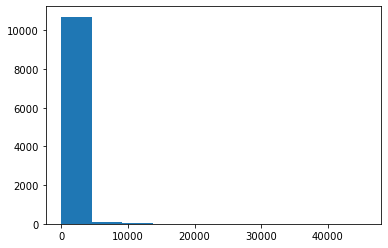

*** asm_commands_call: 1993


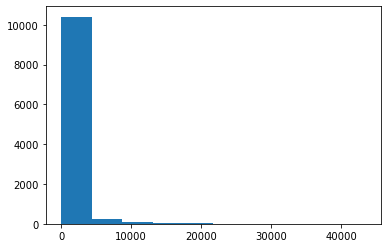

*** asm_commands_cdq: 191


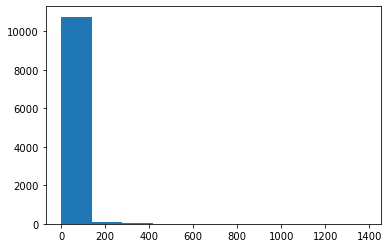

*** asm_commands_cld: 210


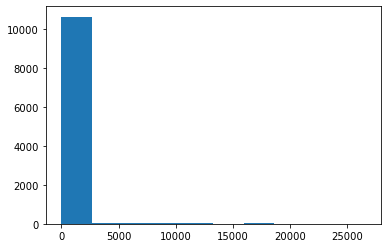

*** asm_commands_cli: 200


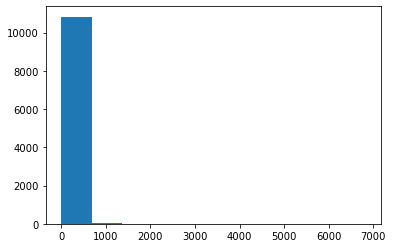

*** asm_commands_cmc: 54


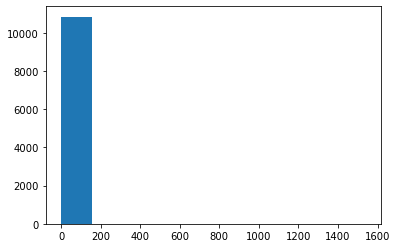

*** asm_commands_cmp: 1563


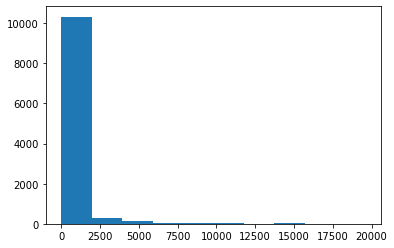

*** asm_commands_cwd: 46


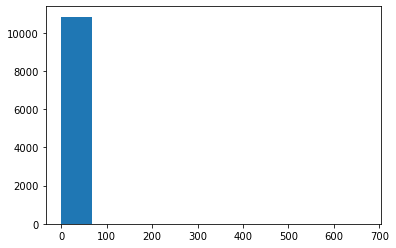

*** asm_commands_daa: 1007


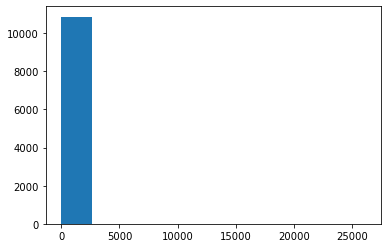

*** asm_commands_dd: 6180


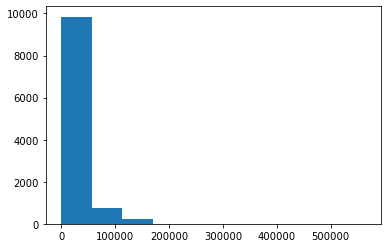

*** asm_commands_dec: 1495


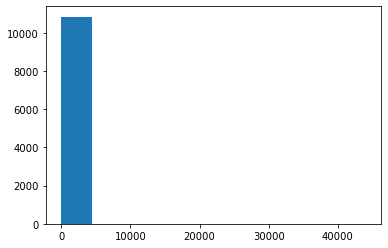

*** asm_commands_dw: 3143


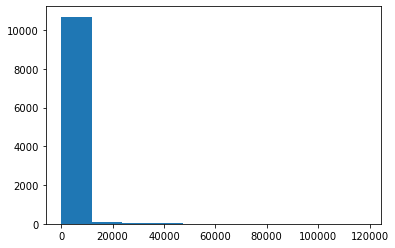

*** asm_commands_endp: 975


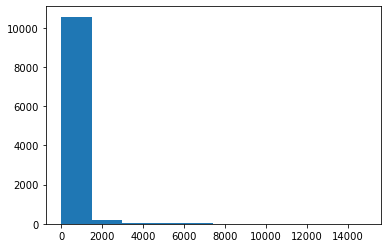

*** asm_commands_faddp: 80


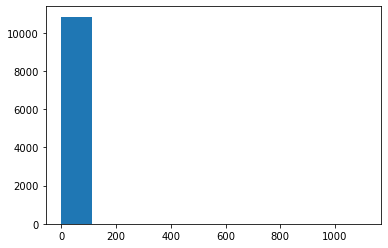

*** asm_commands_fchs: 56


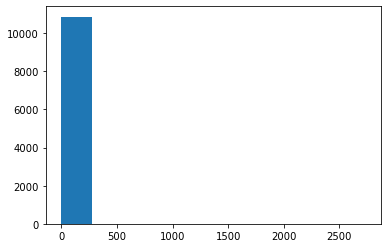

*** asm_commands_fdiv: 92


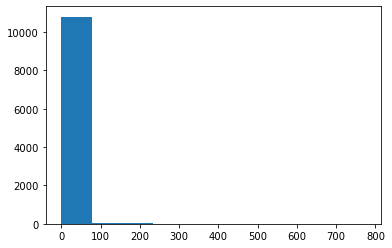

*** asm_commands_fdivr: 52


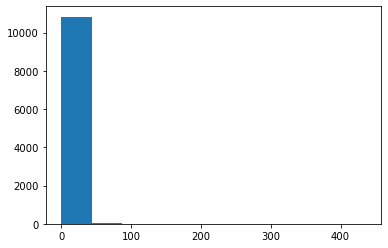

*** asm_commands_fistp: 55


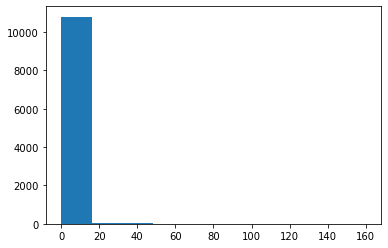

*** asm_commands_fld: 337


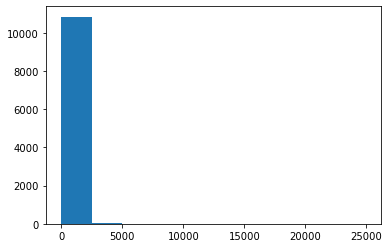

*** asm_commands_fstp: 327


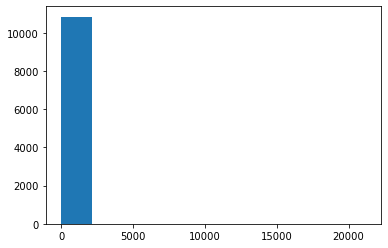

*** asm_commands_fword: 142


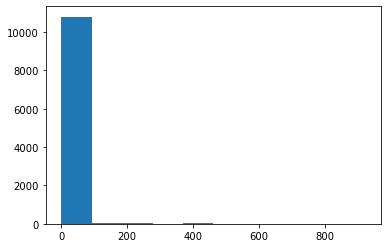

*** asm_commands_fxch: 116


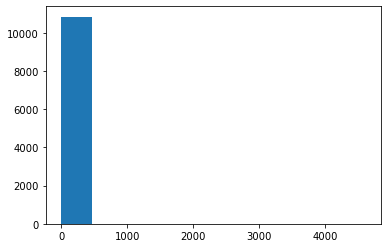

*** asm_commands_imul: 595


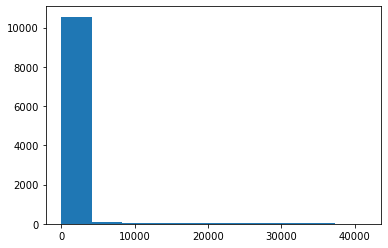

*** asm_commands_in: 2314


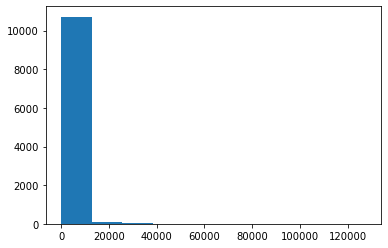

*** asm_commands_inc: 795


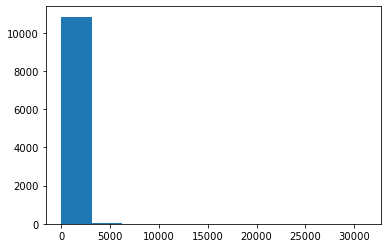

*** asm_commands_ins: 353


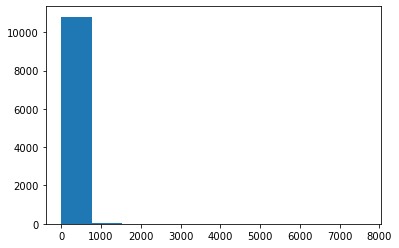

*** asm_commands_jb: 526


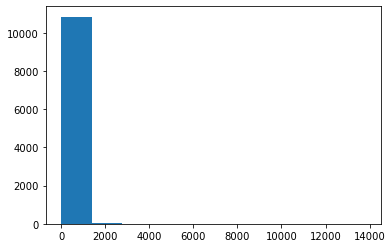

*** asm_commands_je: 354


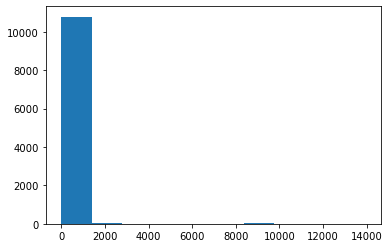

*** asm_commands_jg: 516


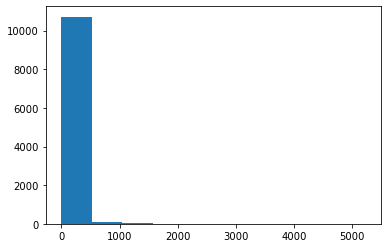

*** asm_commands_jl: 629


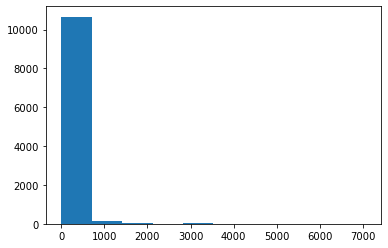

*** asm_commands_jmp: 1351


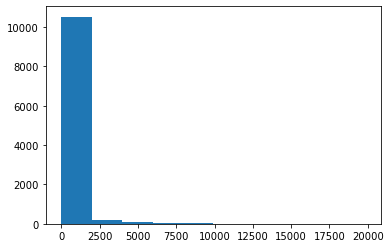

*** asm_commands_jnb: 307


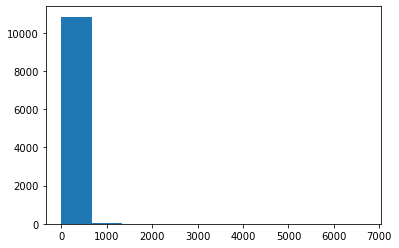

*** asm_commands_jno: 51


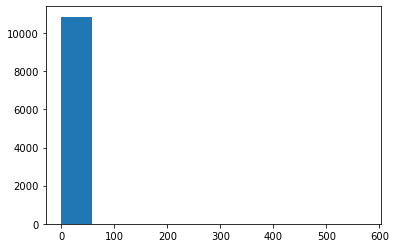

*** asm_commands_jo: 115


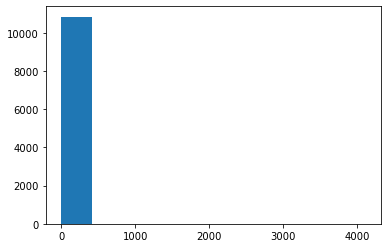

*** asm_commands_jz: 1268


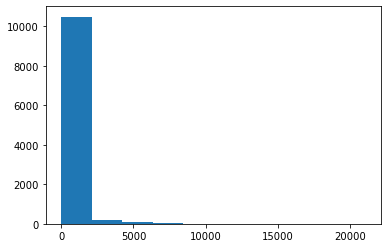

*** asm_commands_lea: 1479


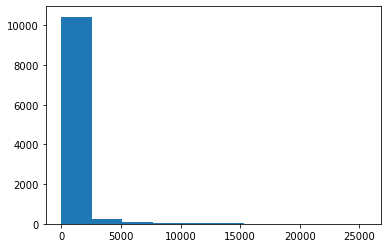

*** asm_commands_mov: 3805


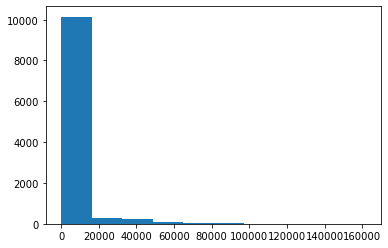

*** asm_commands_mul: 655


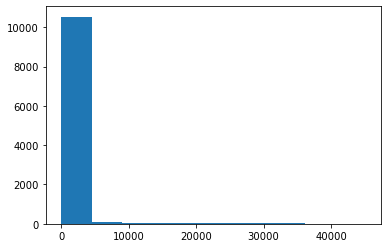

*** asm_commands_not: 329


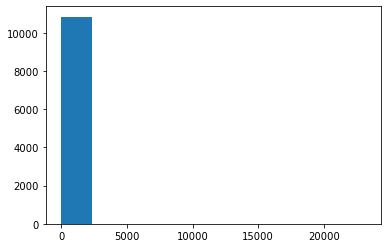

*** asm_commands_or: 4161


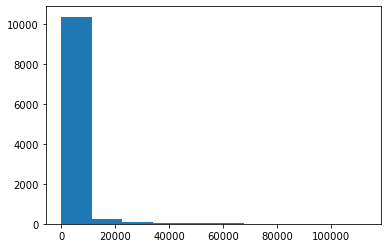

*** asm_commands_out: 258


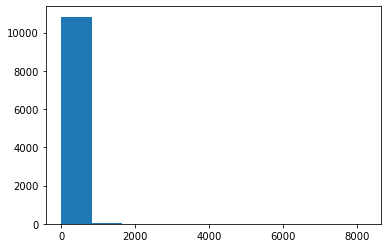

*** asm_commands_outs: 78


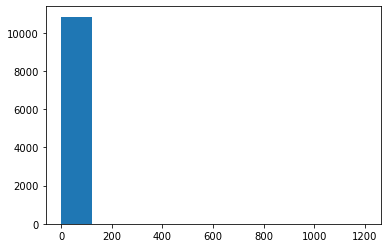

*** asm_commands_pop: 1643


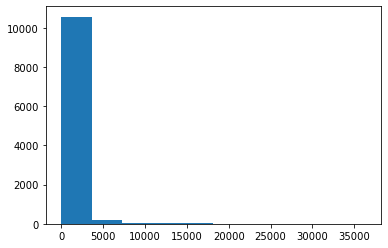

*** asm_commands_push: 2645


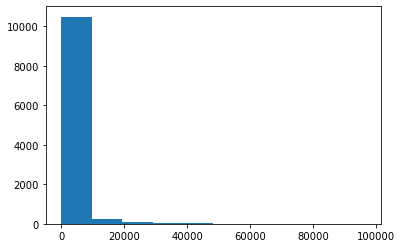

*** asm_commands_rcl: 121


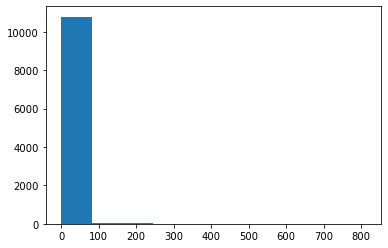

*** asm_commands_rcr: 93


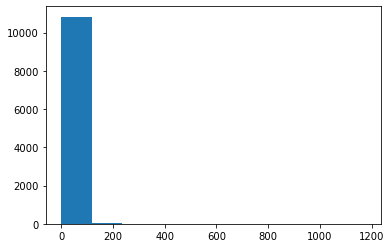

*** asm_commands_rep: 328


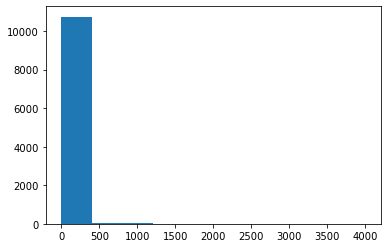

*** asm_commands_ret: 1238


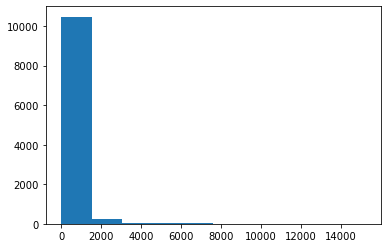

*** asm_commands_rol: 291


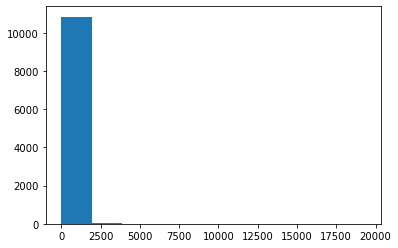

*** asm_commands_ror: 338


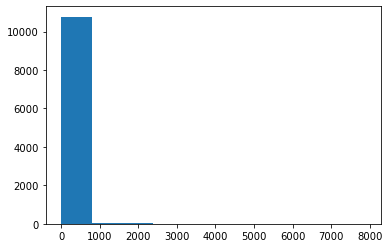

*** asm_commands_sal: 107


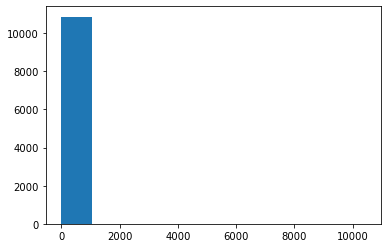

*** asm_commands_sar: 297


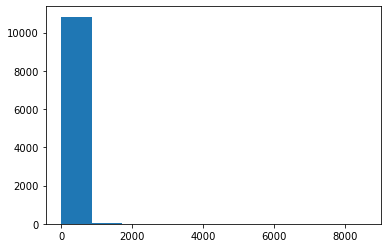

*** asm_commands_sbb: 318


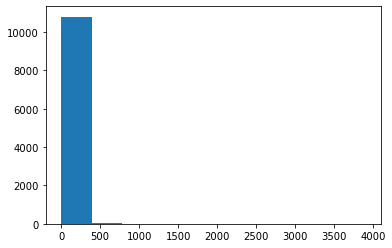

*** asm_commands_scas: 82


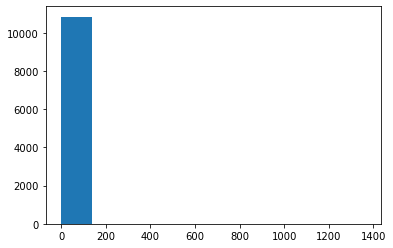

*** asm_commands_shl: 442


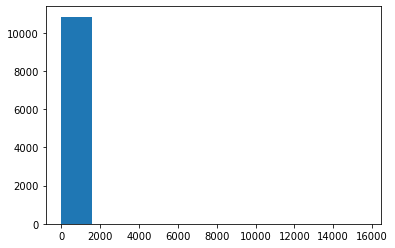

*** asm_commands_shr: 422


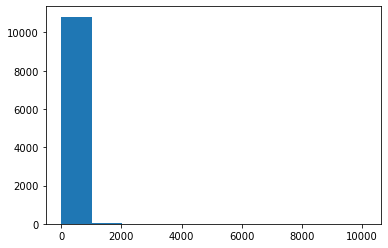

*** asm_commands_sidt: 18


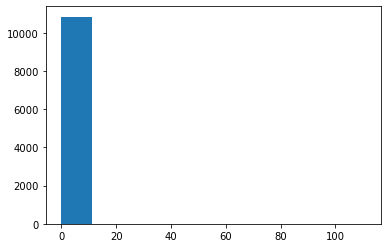

*** asm_commands_stc: 115


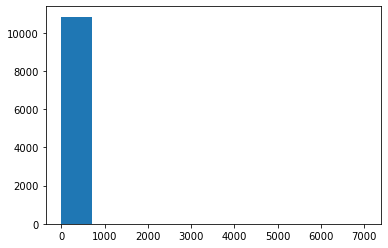

*** asm_commands_std: 855


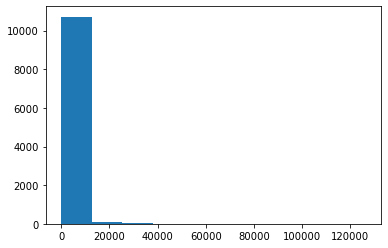

*** asm_commands_sti: 148


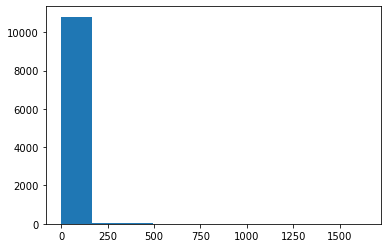

*** asm_commands_stos: 186


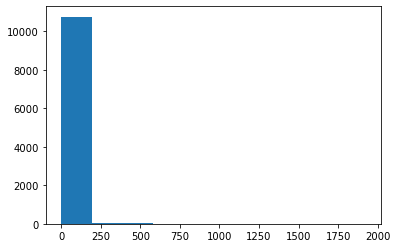

*** asm_commands_sub: 3002


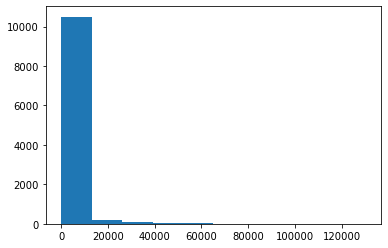

*** asm_commands_test: 1311


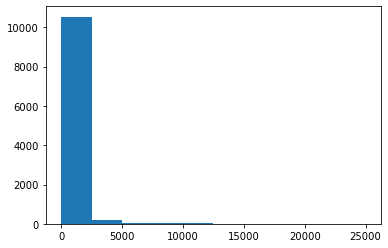

*** asm_commands_wait: 125


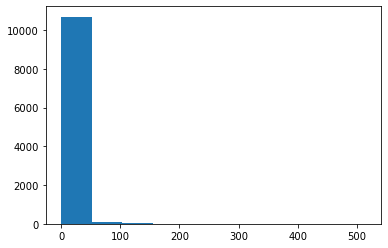

*** asm_commands_xchg: 196


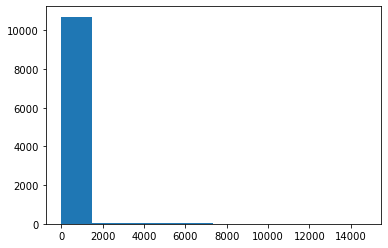

*** asm_commands_xor: 1309


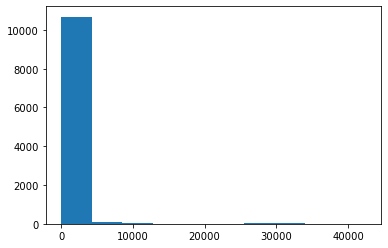

*** line_count_asm: 911


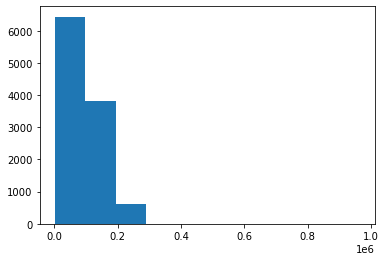

*** size_asm: 990


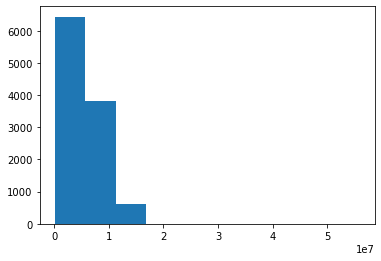

*** Class: 9


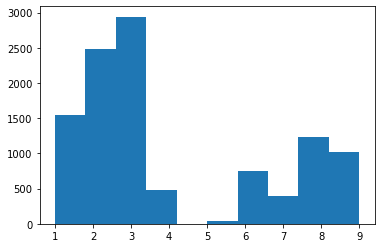

In [14]:
for col in num_columns:
    print(f'*** {col}: {df[col].nunique()}')
    plt.hist(df[col], bins=10)
    plt.show()

asm_commands_add


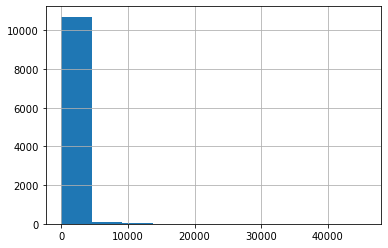


asm_commands_call


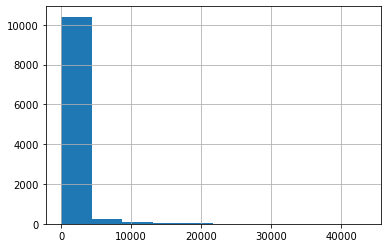


asm_commands_cdq


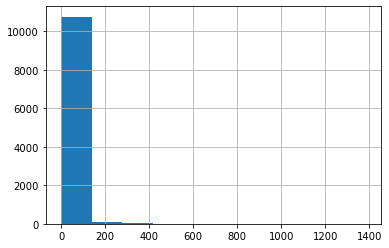


asm_commands_cld


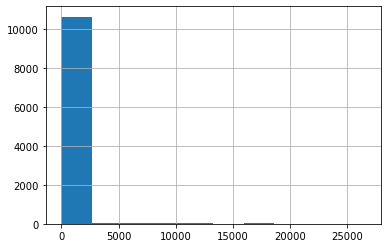


asm_commands_cli


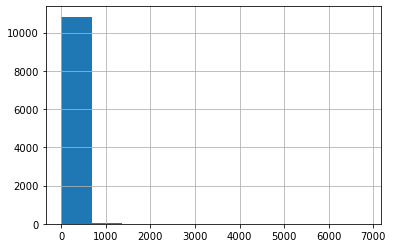


asm_commands_cmc


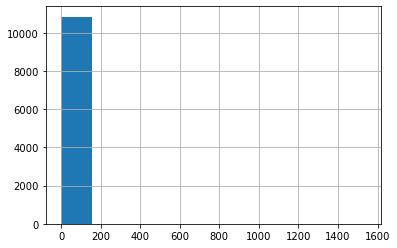


asm_commands_cmp


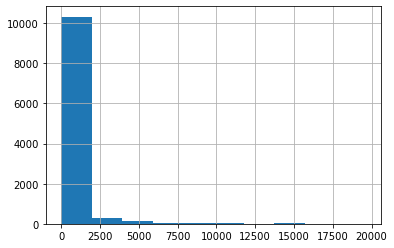


asm_commands_cwd


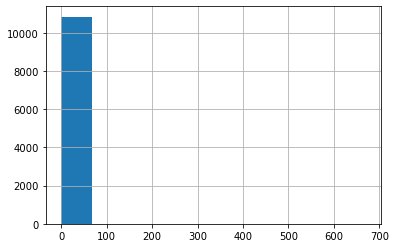


asm_commands_daa


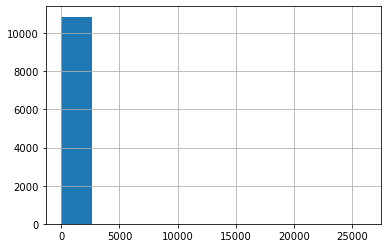


asm_commands_dd


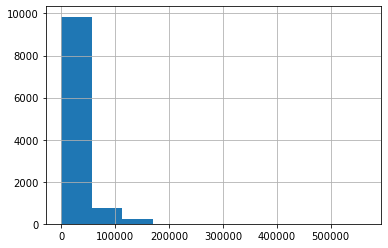


asm_commands_dec


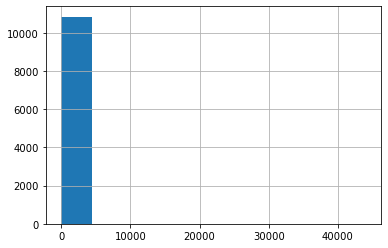


asm_commands_dw


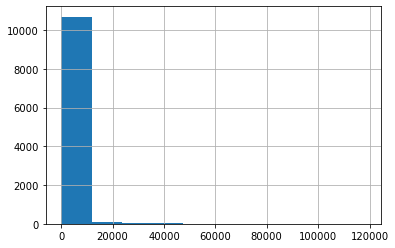


asm_commands_endp


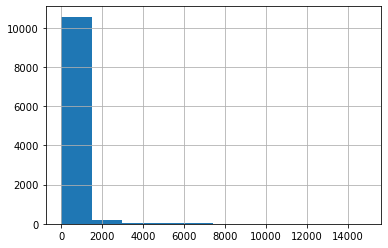


asm_commands_faddp


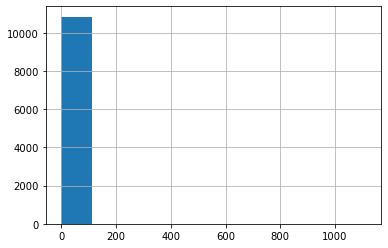


asm_commands_fchs


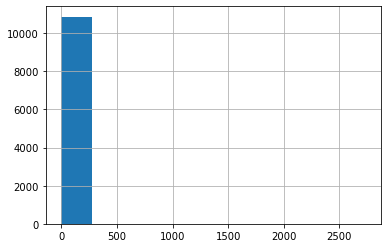


asm_commands_fdiv


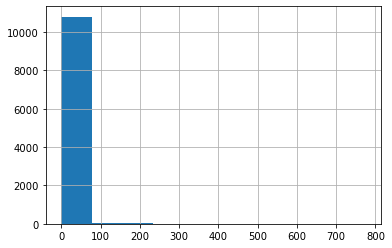


asm_commands_fdivr


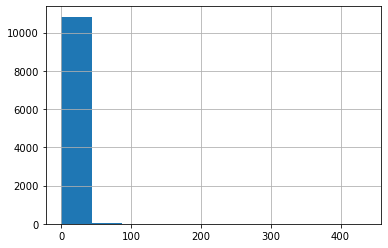


asm_commands_fistp


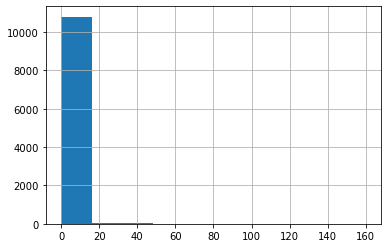


asm_commands_fld


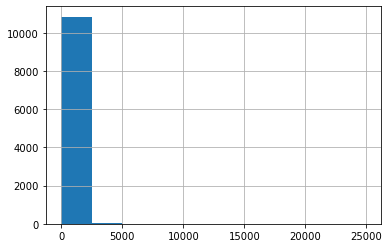


asm_commands_fstp


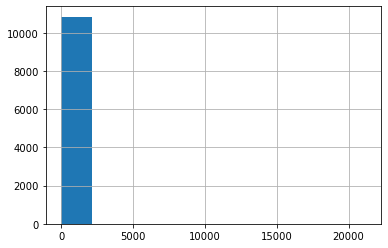


asm_commands_fword


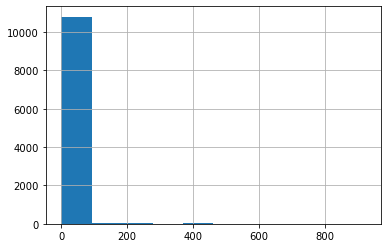


asm_commands_fxch


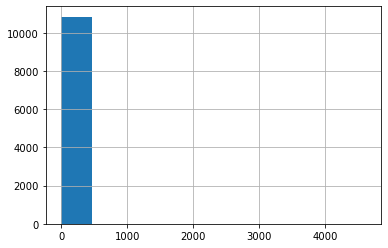


asm_commands_imul


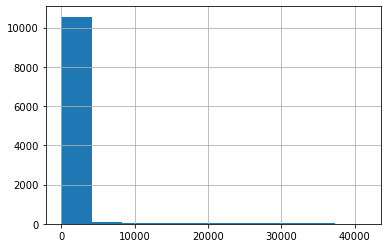


asm_commands_in


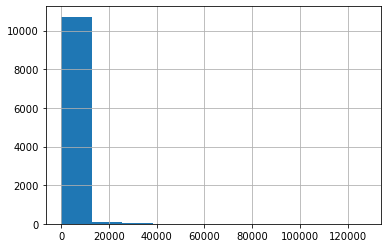


asm_commands_inc


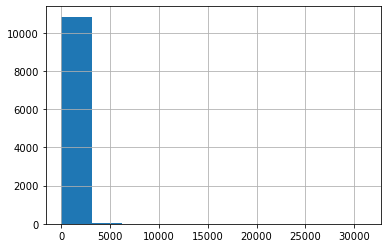


asm_commands_ins


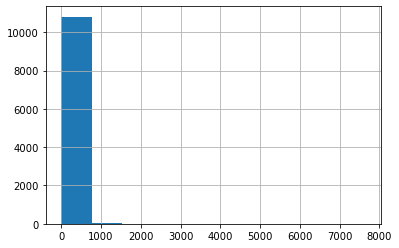


asm_commands_jb


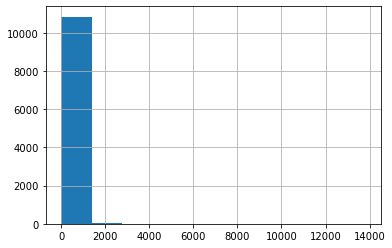


asm_commands_je


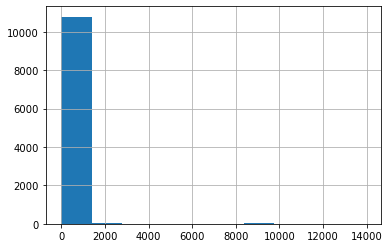


asm_commands_jg


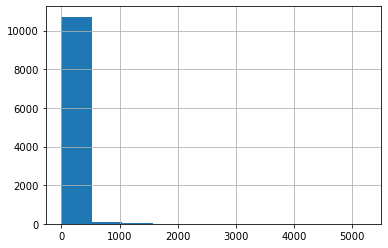


asm_commands_jl


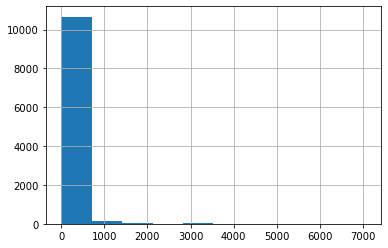


asm_commands_jmp


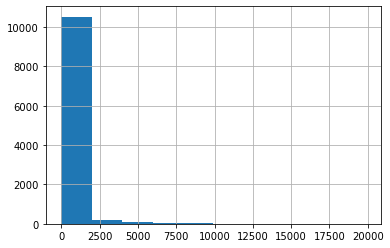


asm_commands_jnb


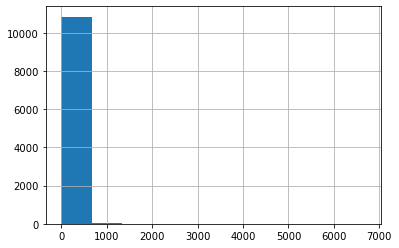


asm_commands_jno


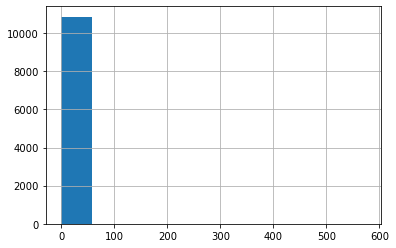


asm_commands_jo


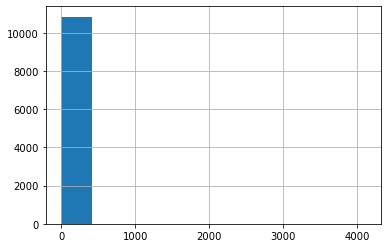


asm_commands_jz


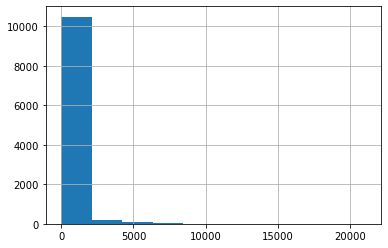


asm_commands_lea


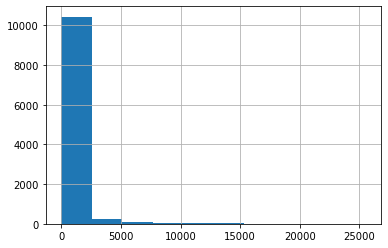


asm_commands_mov


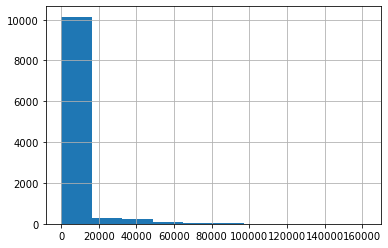


asm_commands_mul


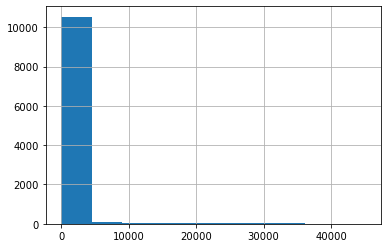


asm_commands_not


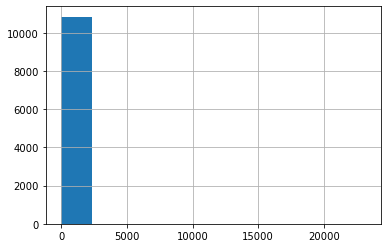


asm_commands_or


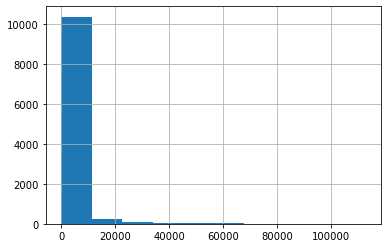


asm_commands_out


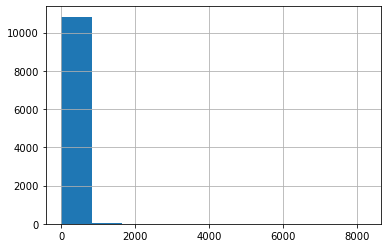


asm_commands_outs


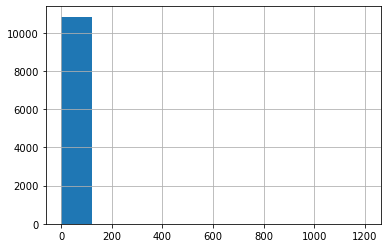


asm_commands_pop


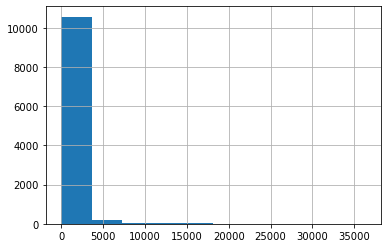


asm_commands_push


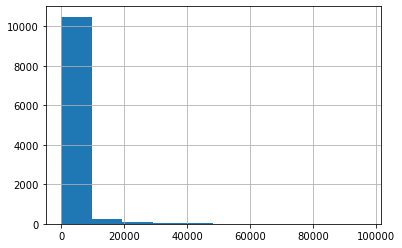


asm_commands_rcl


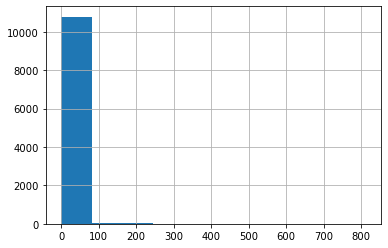


asm_commands_rcr


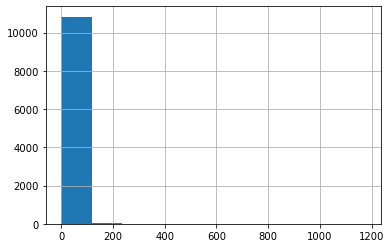


asm_commands_rep


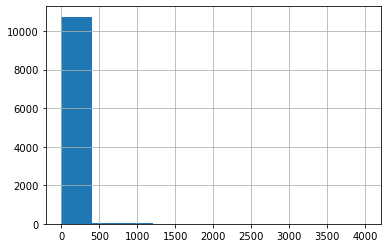


asm_commands_ret


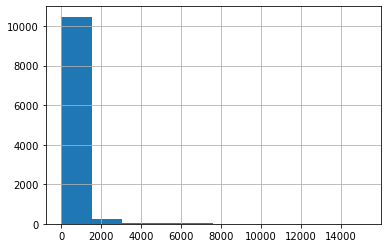


asm_commands_rol


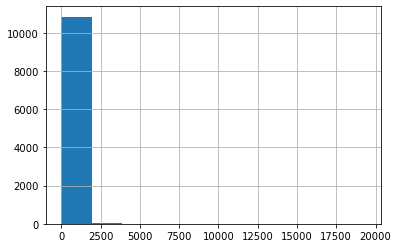


asm_commands_ror


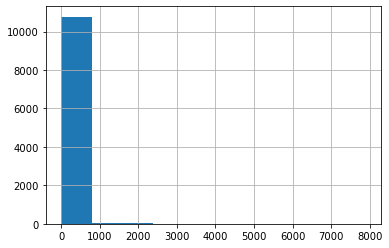


asm_commands_sal


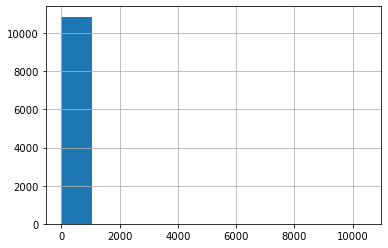


asm_commands_sar


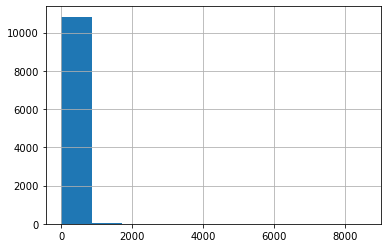


asm_commands_sbb


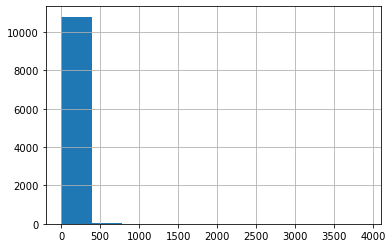


asm_commands_scas


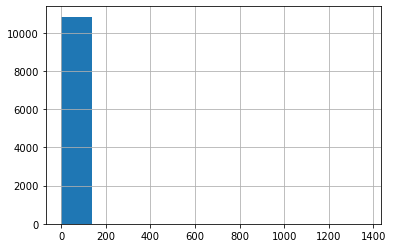


asm_commands_shl


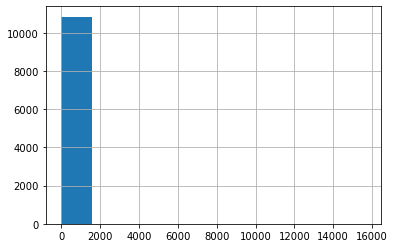


asm_commands_shr


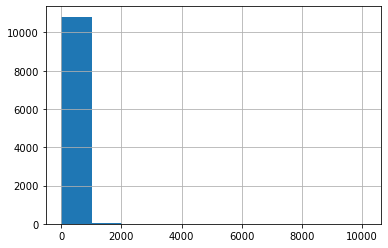


asm_commands_sidt


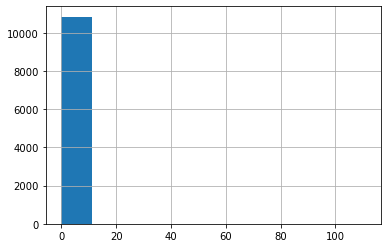


asm_commands_stc


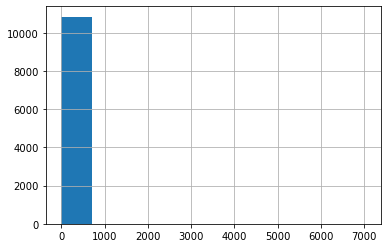


asm_commands_std


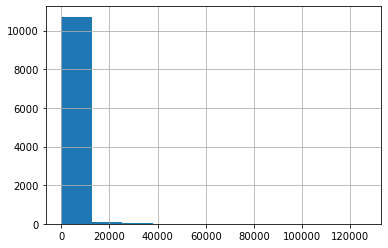


asm_commands_sti


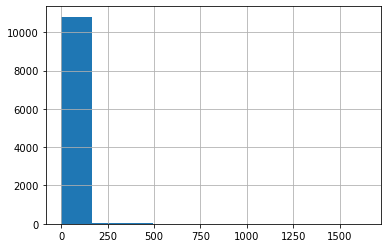


asm_commands_stos


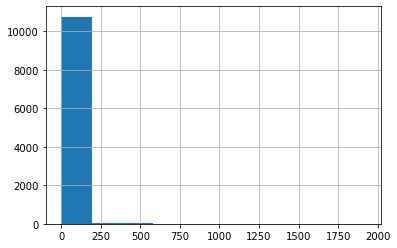


asm_commands_sub


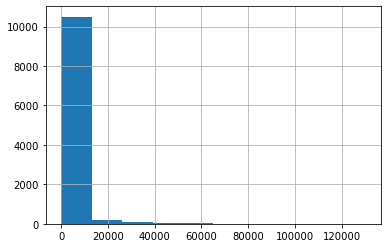


asm_commands_test


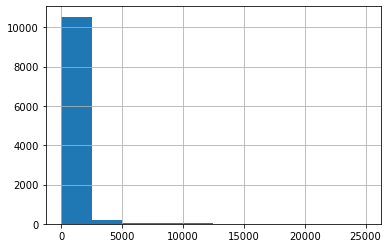


asm_commands_wait


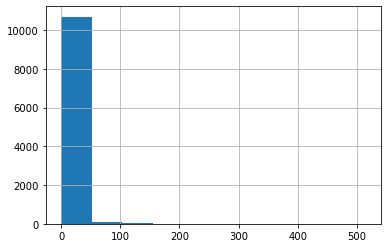


asm_commands_xchg


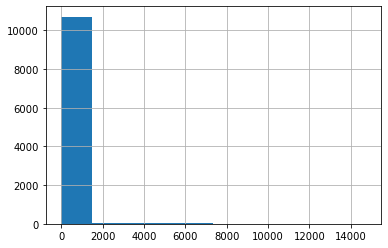


asm_commands_xor


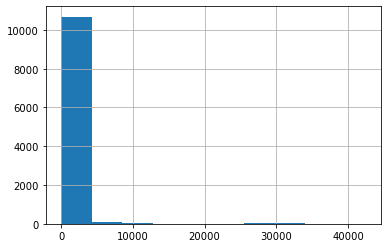


line_count_asm


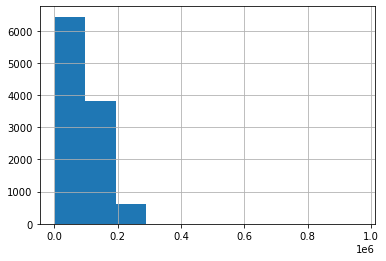


size_asm


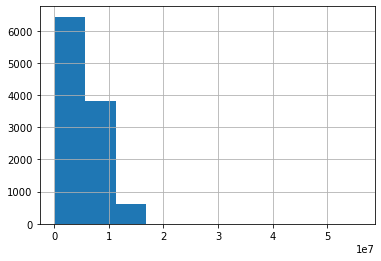


Class


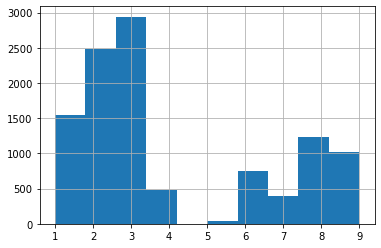

In [15]:
for col in df:
    print(col)
    df[col].hist(bins=10)
    plt.show()
    print()

I check individual statistical metrics for variables. We see a very high standard deviation, which
suggests that most of the variables are not normally distributed. Additionally, many variables although there are no missing values
consists mostly of zeros.

In [16]:
df.describe()

asm_commands_add  asm_commands_call  asm_commands_cdq  \
count      10868.000000       10868.000000      10868.000000   
mean         724.463839         958.675377         10.774384   
std         1568.276158        2891.049563         39.071261   
min            6.000000           0.000000          0.000000   
25%          140.000000         178.000000          0.000000   
50%          362.000000         261.000000          0.000000   
75%          766.000000         609.000000         16.000000   
max        45684.000000       43479.000000       1384.000000   

       asm_commands_cld  asm_commands_cli  asm_commands_cmc  asm_commands_cmp  \
count      10868.000000      10868.000000      10868.000000      10868.000000   
mean         200.203165         16.794258          1.900074        480.152742   
std         1567.778035        184.439789         35.070993       1384.428550   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          8.000000   
50%            0.000000          1.000000          0.000000        134.500000   
75%            2.000000          6.000000          0.000000        401.000000   
max        26600.000000       6830.000000       1540.000000      19617.000000   

       asm_commands_cwd  asm_commands_daa  asm_commands_dd  ...  \
count      10868.000000      10868.000000     10868.000000  ...   
mean           1.411115        221.034321     16995.688167  ...   
std           13.709346        498.249596     32916.498115  ...   
min            0.000000          0.000000        12.000000  ...   
25%            0.000000          2.000000       217.000000  ...   
50%            0.000000         37.000000      3328.500000  ...   
75%            0.000000        183.000000     18256.000000  ...   
max          670.000000      26147.000000    565024.000000  ...   

       asm_commands_sti  asm_commands_stos  asm_commands_sub  \
count      10868.000000       10868.000000      10868.000000   
mean           6.146669          15.102135       2156.040302   
std           36.775391          55.051804       6674.654957   
min            0.000000           0.000000          0.000000   
25%            0.000000           0.000000        322.000000   
50%            1.000000           1.000000        640.000000   
75%            2.000000          22.000000       1383.000000   
max         1641.000000        1924.000000     130324.000000   

       asm_commands_test  asm_commands_wait  asm_commands_xchg  \
count       10868.000000       10868.000000       10868.000000   
mean          330.867777           6.230861          71.709698   
std          1107.955680          17.015893         581.487035   
min             0.000000           0.000000           0.000000   
25%             7.000000           0.000000           0.000000   
50%            50.000000           3.000000           1.000000   
75%           188.000000           7.000000           3.000000   
max         25008.000000         515.000000       14725.000000   

       asm_commands_xor  line_count_asm      size_asm         Class  
count      10868.000000    10868.000000  1.086800e+04  10868.000000  
mean         493.072874    80667.184026  4.678640e+06      4.017851  
std         2468.536914    64475.348289  3.739570e+06      2.684621  
min            0.000000     1942.000000  1.126280e+05      1.000000  
25%           13.000000    15105.000000  8.760320e+05      2.000000  
50%           81.500000    75364.500000  4.371121e+06      3.000000  
75%          273.000000   146433.000000  8.493056e+06      6.000000  
max        42457.000000   963585.000000  5.588787e+07      9.000000  

[8 rows x 69 columns]

I divide the dataset into a test and training part. Set random seed for reproducible results. I choose the target variable accordingly.

In [17]:

seed = 7
test_size = 0.33
train, test = train_test_split(df, test_size=test_size, random_state=seed)

target_col = 'Class'
X_train, y_train = train.drop(target_col, axis=1), train[target_col]
X_test, y_test = test.drop(target_col, axis=1), test[target_col]

The data is divided into 9 unequal classes. The largest accounts for almost 30%, the smallest 0.3% of all records. This suggests using the methods of UnderSampler or OverSampler.

In [18]:
y_train.value_counts()


3    1978
2    1658
1    1047
8     818
9     652
6     507
4     324
7     268
5      29
Name: Class, dtype: int64

In [19]:
y_train.value_counts(normalize=True)

3    0.271666
2    0.227716
1    0.143799
8    0.112347
9    0.089548
6    0.069633
4    0.044499
7    0.036808
5    0.003983
Name: Class, dtype: float64

Algorithms

I test different algorithms to check which of them will best cope with the test sample.
First, we check the DummyClassifier. It does not show good results due to too many classes and too much data dispersion.

In [20]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy.predict(X_train)




array([3, 3, 3, ..., 3, 3, 3], dtype=int64)

In [21]:
Best_models ={}

In [88]:
print("Test mean accuracy: ",dummy.score(X_test, y_test))
preds = dummy.predict(X_test)
print("Test prediction score: ", precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))

Best_models['DummyClassifier'] = precision_score(y_test, preds, average='weighted')

Test mean accuracy:  0.2687482575968776
Test prediction score:  0.07222562596135769
Test recall score:  0.2687482575968776
Test f1 score:  0.1138533598432828


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I am creating a dictionary to which I will add the result of the mean accuracy created models

In [89]:
Best_models['DummyClassifier']

0.07222562596135769

I check how the logistic regression will handle the data

In [24]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_train)

print("Test mean accuracy: ",lr.score(X_test, y_test))
preds = lr.predict(X_test)
print("Test prediction score: ", precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))

Best_models['LogisticRegression'] = lr.score(X_test, y_test)

Test mean accuracy:  0.6275439085586841
Test prediction score:  0.46658996701059635
Test recall score:  0.6275439085586841
Test f1 score:  0.5197443527225448


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


During the data analysis, it was possible to reach different orders of values for individual variables, which significantly weakens its
logistic regression results. So I'm implementing data scaling to minimize this problem

In [25]:
print(Best_models)

{'DummyClassifier': 'Test mean accuracy:  0.2687482575968776', 'LogisticRegression': 0.6275439085586841}


In [26]:
lr_model = make_pipeline(StandardScaler(),
                          LogisticRegression())
lr_model.fit(X_train, y_train)


lr = lr_model
print("Test mean accuracy: ",lr.score(X_test, y_test))
preds = lr.predict(X_test)
print("Test prediction score: ", precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))

Best_models['LogisticRegression + StandardScaler'] = lr.score(X_test, y_test)

Test mean accuracy:  0.9498187900752718
Test prediction score:  0.9489303800764065
Test recall score:  0.9498187900752718
Test f1 score:  0.9486445302502697


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


To analyze the effectiveness of the models, I will use four measures: precision_score, recall_score, f1_score, and accuracy_score.
Their high values best reflect the correctness of the model, additionally, when used together, they allow you to assess whether the algorithm is performing
does not misunderstand.
Helpfully, in the case of the best models, I will also use the confusion matrix to see what class,
the algorithm has the biggest problem.

In [27]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [28]:
y_pred_lr_train=lr.predict(X_train)
y_pred_lr_test=lr.predict(X_test)
preds = lr_model.predict(X_test)
print('Classification Report : ',classification_report(y_train,y_pred_lr_train))
print('***********')
print('Classification Report : ',classification_report(y_test,y_pred_lr_test))

Classification Report :                precision    recall  f1-score   support

           1       0.92      0.95      0.93      1047
           2       0.99      0.98      0.99      1658
           3       0.99      1.00      0.99      1978
           4       0.90      0.99      0.94       324
           5       1.00      0.24      0.39        29
           6       0.92      0.96      0.94       507
           7       0.92      0.95      0.94       268
           8       0.96      0.91      0.93       818
           9       0.97      0.93      0.95       652

    accuracy                           0.96      7281
   macro avg       0.95      0.88      0.89      7281
weighted avg       0.96      0.96      0.96      7281

***********
Classification Report :                precision    recall  f1-score   support

           1       0.90      0.89      0.89       494
           2       0.98      0.98      0.98       820
           3       0.99      1.00      1.00       964
           4    

In [29]:
print('Confusion Matrix : ',confusion_matrix(y_test,y_pred_lr_test))

Confusion Matrix :  [[438  10   0  10   1   4   3  21   7]
 [ 14 804   1   0   0   0   0   1   0]
 [  0   0 964   0   0   0   0   0   0]
 [  0   0   0 151   0   0   0   0   0]
 [  0   0   6   0   1   1   0   5   0]
 [  2   2   1   8   0 229   2   0   0]
 [  1   1   0   2   0   0 124   0   2]
 [ 27   2   0   7   0   3   3 366   2]
 [  6   2   0   0   1  21   0   1 330]]


The use of cross-validation will be an additional safeguard if the algorithm adapts too well to the data.
it will also help to avoid errors caused by inappropriate randomization of data into the test and training sets.

In [30]:
from sklearn.model_selection import cross_val_score
cs = cross_val_score(LogisticRegression(max_iter=10000), X_train, y_train, cv=10)
cs.mean()


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

0.8847689518985815

We have already checked how linear regression fared, now let's see how they will cope with the classification problem
individual algorithms: RandomForestClassifier, DecisionTreeClassifier, XGBClassifier, SVC.

In [31]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

preds = rf_model.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))

Best_models['RandomForestClassifier'] = rf_model.score(X_test, y_test)

Test prediction score:  0.9891365268145881
Test recall score:  0.988848620016727
Test f1 score:  0.9888713988346788
Test accuracy:  0.988848620016727


In [32]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

preds = dt_model.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))

Best_models['DecisionTreeClassifier'] = dt_model.score(X_test, y_test)

Test prediction score:  0.9690681176462248
Test recall score:  0.9687761360468358
Test f1 score:  0.9688797706394682
Test accuracy:  0.9687761360468358


In [33]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

preds = xgb_model.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))

Best_models['XGBClassifier'] = xgb_model.score(X_test, y_test)

Test prediction score:  0.9890504737353839
Test recall score:  0.988848620016727
Test f1 score:  0.9888614907343504
Test accuracy:  0.988848620016727


In [34]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
preds = svc_model.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))

Best_models['SVC'] = svc_model.score(X_test, y_test)

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test prediction score:  0.4116543275700344
Test recall score:  0.5054362977418455
Test f1 score:  0.4446297129115361
Test accuracy:  0.5054362977418455


Like linear regressions, the SVC algorithm should be used on scaled data.

In [35]:
svr_model = make_pipeline(StandardScaler(),
                          SVC(random_state=42))
svr_model.fit(X_train, y_train)
preds = svr_model.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))

Best_models['SVC + StandardScaler'] = svc_model.score(X_test, y_test)

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test prediction score:  0.9363701083493202
Test recall score:  0.9372734875940898
Test f1 score:  0.93568425541853
Test accuracy:  0.9372734875940898


So we can see that using the default parameters we can indicate that XGBClassifier works best
and RandomForestClassifier, and the worst SVC.

I am now checking how the results of individual algorithms will be affected by changes in class weights. However, this is not an optimal solution
to type it manually, so for automation, I'm closing it in a loop. Given the number of parameters we have in
For individual algorithms, however, it will be better to use ready-made functions such as RandomizedSearchCV and GridSearchCV

In [36]:
weights = [2, 5, 10, 20, 30, 50]

for w in weights:
    lr = LogisticRegression(class_weight={1:10, 1:w})
    lr.fit(X_train, y_train)
    
    preds = lr.predict(X_test)
    print("weights:", w)
    print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
    print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
    print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
    print("Test accuracy: ",accuracy_score(y_test, preds))

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weights: 2
Test prediction score:  0.4651126079605173
Test recall score:  0.6275439085586841
Test f1 score:  0.5187150402618361
Test accuracy:  0.6275439085586841


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weights: 5
Test prediction score:  0.4050416925139195
Test recall score:  0.5695567326456649
Test f1 score:  0.4664729256751041
Test accuracy:  0.5695567326456649


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weights: 10
Test prediction score:  0.41707373926405467
Test recall score:  0.5508781711736828
Test f1 score:  0.4610496543800578
Test accuracy:  0.5508781711736828


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weights: 20
Test prediction score:  0.39870224039599017
Test recall score:  0.5296905492054642
Test f1 score:  0.4378070288647354
Test accuracy:  0.5296905492054642


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


weights: 30
Test prediction score:  0.40317641647210084
Test recall score:  0.5280178422079732
Test f1 score:  0.4386653649536582
Test accuracy:  0.5280178422079732
weights: 50
Test prediction score:  0.40158080704751375
Test recall score:  0.520490660719264
Test f1 score:  0.4328238215083062
Test accuracy:  0.520490660719264


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
%%time
for w in weights:
    dt = DecisionTreeClassifier(class_weight={1:10, 1:w})
    dt.fit(X_train, y_train)    
    preds = dt.predict(X_test)
    print("weights:", w)  
    print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
    print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
    print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
    print("Test accuracy: ",accuracy_score(y_test, preds))

weights: 2
Test prediction score:  0.9653082822588734
Test recall score:  0.9654307220518539
Test f1 score:  0.9652173155808587
Test accuracy:  0.9654307220518539
weights: 5
Test prediction score:  0.9687718775302648
Test recall score:  0.9687761360468358
Test f1 score:  0.9686993855307788
Test accuracy:  0.9687761360468358
weights: 10
Test prediction score:  0.9676118411864771
Test recall score:  0.9671034290493449
Test f1 score:  0.9672318245579914
Test accuracy:  0.9671034290493449
weights: 20
Test prediction score:  0.9674942501010083
Test recall score:  0.9671034290493449
Test f1 score:  0.9671746604332968
Test accuracy:  0.9671034290493449
weights: 30
Test prediction score:  0.9684619349541501
Test recall score:  0.9682185670476722
Test f1 score:  0.9682674559514951
Test accuracy:  0.9682185670476722
weights: 50
Test prediction score:  0.9644674112559256
Test recall score:  0.9643155840535266
Test f1 score:  0.9642074475985113
Test accuracy:  0.9643155840535266
Wall time: 1.17 s


On the occasion of working with tree algorithms, he visualizes on a graph what the division of data may look like.

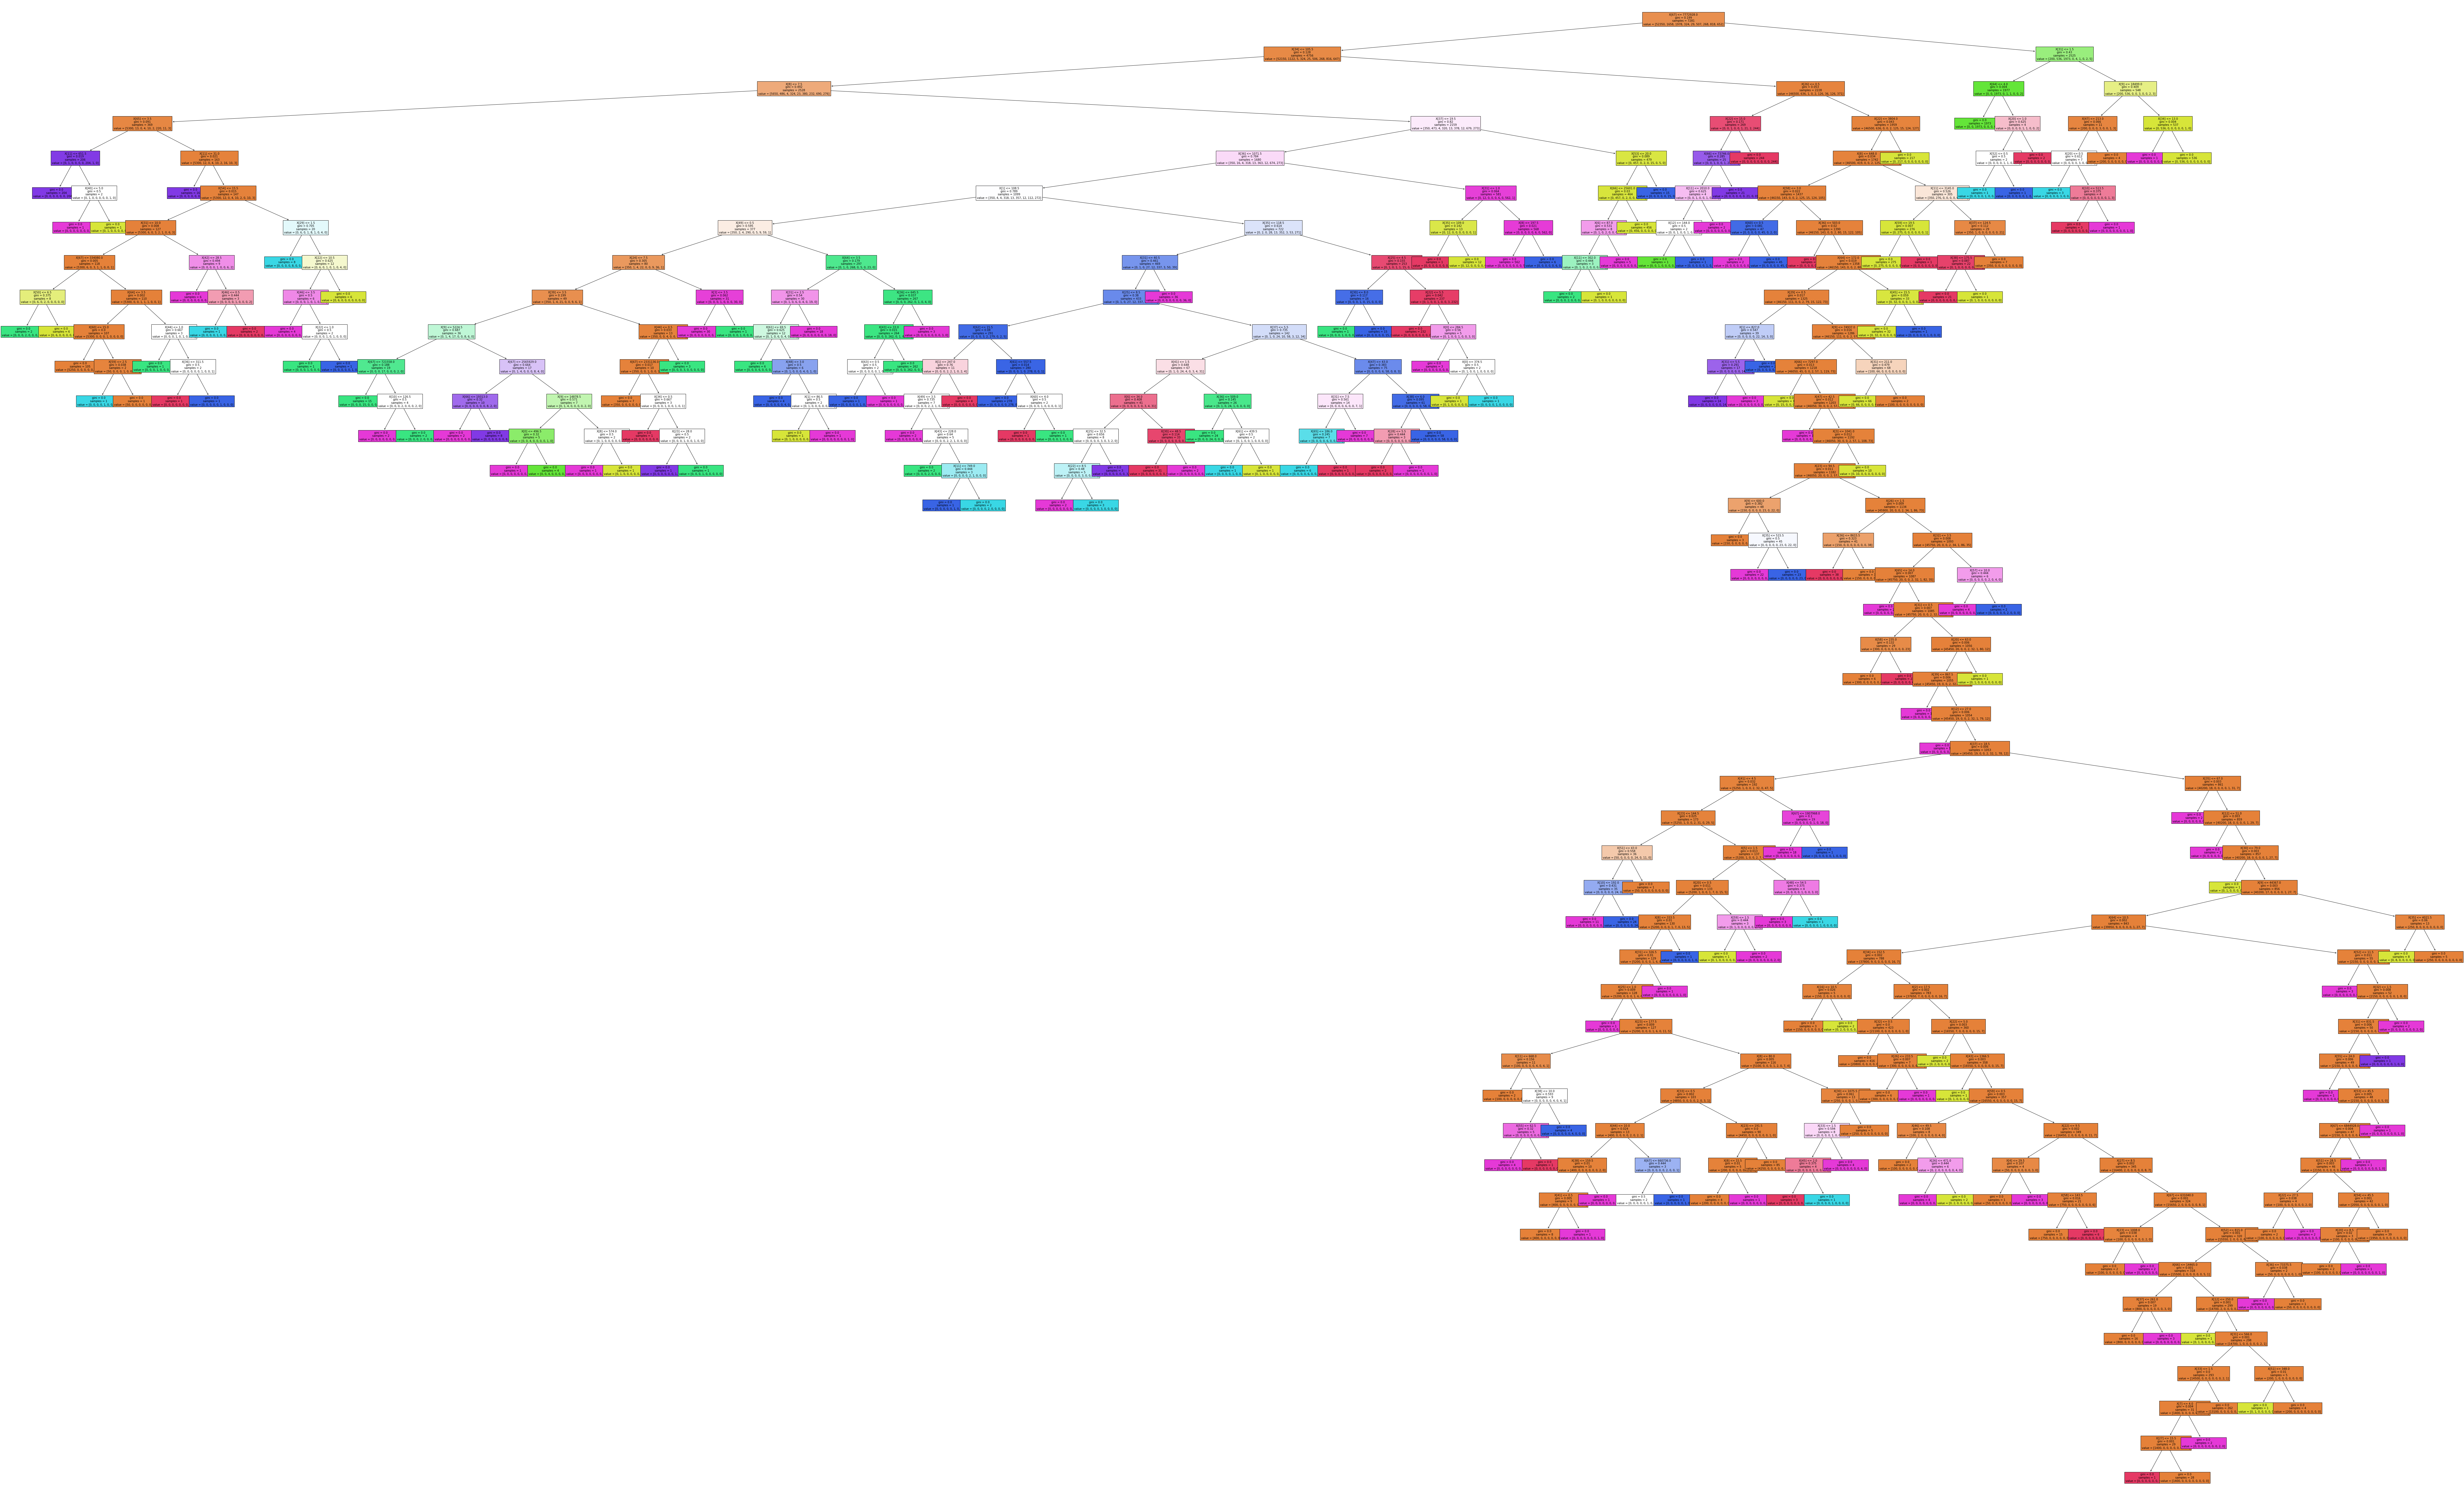

In [38]:
import sklearn
from sklearn.tree import plot_tree
plt.figure(figsize=(160,100))  
plot_tree(dt, fontsize=10, filled=True)  
plt.show()

In [39]:
dt.tree_.max_depth

42

I use the most optimal optimization method - GridSearchCV, on one of the best models that have been obtained so far.

In [40]:
%%time
rfc=RandomForestClassifier(random_state=7)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

preds = CV_rfc.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))

Best_models['RandomForestClassifier + GridSearchCV'] = CV_rfc.score(X_test, y_test)

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Test prediction score:  0.9844441884218775
Test recall score:  0.9838304990242542
Test f1 score:  0.9837861165660154
Test accuracy:  0.9838304990242542
Wall time: 15min 44s


In [41]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

Unfortunately, among the many advantages of this method, it has one disadvantage - resource consumption and duration. So I use a RandomizedSearchCV to get close to the correct answer at the optimal time. Then I will use the GridSearchCVto find the best parameters, not just close to the best.

In [42]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

preds = rf_random.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))

Best_models['RandomForestRegressor + RandomizedSearchCV'] = rf_random.score(X_test, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Test prediction score:  0.9893569667661991
Test recall score:  0.9891274045163089
Test f1 score:  0.9891367910228003
Test accuracy:  0.9891274045163089
Wall time: 14min 45s


In [43]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [44]:
%%time

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [30,40,50],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1,2,3],
    'n_estimators': [1300, 1350, 1400, 1450, 1500]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

preds = grid_search.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))

Best_models['RandomForestClassifier + GridSearchCV + RandomizedSearchCV'] = grid_search.score(X_test, y_test)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
270 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "D:\Anaconda\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\Anaconda\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._d

Test prediction score:  0.9902065570838595
Test recall score:  0.9899637580150543
Test f1 score:  0.9899729667008317
Test accuracy:  0.9899637580150543
Wall time: 18min 18s


In [45]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1450}

In [46]:
%%time
estimator = XGBClassifier(
    nthread=4,
    seed=7
)

parameters = {
    'max_depth': range (2, 60, 1),
    'n_estimators': range(100, 1500, 100),
    'learning_rate': [0.1, 0.01, 0.05],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

random_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Wall time: 1h 22min 56s


RandomizedSearchCV(cv=10, estimator=XGBClassifier(nthread=4, seed=7), n_jobs=10,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': range(2, 60),
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': range(100, 1500, 100),
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='roc_auc', verbose=True)

In [47]:
random_search.best_params_

{'subsample': 0.8,
 'n_estimators': 1100,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.01,
 'gamma': 1.5,
 'colsample_bytree': 1.0}

In [48]:
%%time
estimator = XGBClassifier(
    nthread=4,
    seed=7
)

parameters = {
    'max_depth': range (6, 7, 1),
    'n_estimators': range(500, 525, 25),
    'learning_rate': [0.04, 0.05],
    'min_child_weight': [1, 5],
    'gamma': [1.25, 1.5],
    'subsample': [0.5, 0.6],
    'colsample_bytree': [0.7, 0.8]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train)

preds = grid_search.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))



Fitting 10 folds for each of 32 candidates, totalling 320 fits


D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Test prediction score:  0.9876500773613031
Test recall score:  0.987454697518818
Test f1 score:  0.9873952613510094
Test accuracy:  0.987454697518818
Wall time: 2h 15min 35s


In [49]:
grid_search.best_estimator_

XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)

The best model at the moment turned out to be - XGBClassifier RandomForestClassifier Obtaining:


It is now analyzing the data structure to try to improve the result. I will use the best parameters obtained from GridSearchCV.

I see the algorithms have the highest percentage error with class 5 being the least.
I carry out an analysis of the number of classes. I see a big difference between it
the majority class and the minority class. So I introduce methods to minimize the differences and improve the performance of the algorithm.

In [50]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [51]:
y_train.value_counts()

3    1978
2    1658
1    1047
8     818
9     652
6     507
4     324
7     268
5      29
Name: Class, dtype: int64

In [52]:
y_train.value_counts(normalize=True)

3    0.271666
2    0.227716
1    0.143799
8    0.112347
9    0.089548
6    0.069633
4    0.044499
7    0.036808
5    0.003983
Name: Class, dtype: float64

Tests the effects of hanging and downsampling on algorithms that performed best
yourself in the early part of the project.

In [53]:
rus = RandomUnderSampler(random_state=42) 
X_res, y_res = rus.fit_resample(X_train, y_train)

In [54]:
X_res.shape, y_res.shape

((261, 68), (261,))

In [55]:
rf_model = RandomForestClassifier(bootstrap = False, max_depth = 50, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1300)
rf_model.fit(X_res, y_res)
print("RandomForestClassifier")
preds =rf_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['RandomForestClassifier + RandomUnderSampler'] = rf_model.score(X_test, y_test)

xgb_model = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)
xgb_model.fit(X_res, y_res)
print("XGBClassifier")
preds = xgb_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['XGBClassifier + RandomUnderSampler'] = xgb_model.score(X_test, y_test)

RandomForestClassifier
Test prediction score:  0.9443528596265643
Test recall score:  0.9311402286032897
Test f1 score:  0.9338491467618432
Test accuracy:  0.9311402286032897
XGBClassifier
Test prediction score:  0.9241634742995535
Test recall score:  0.9185949261221076
Test f1 score:  0.9187794008222205
Test accuracy:  0.9185949261221076


In [56]:
rus = RandomUnderSampler(sampling_strategy='not majority')
X_res, y_res = rus.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(bootstrap = False, max_depth = 50, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1300)
rf_model.fit(X_res, y_res)
print("RandomForestClassifier")
preds =rf_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['RandomForestClassifier + RandomUnderSampler - not majority'] = rf_model.score(X_test, y_test)

xgb_model = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)
xgb_model.fit(X_res, y_res)
print("XGBClassifier")

preds = xgb_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['XGBClassifier + RandomUnderSampler - not majority'] = xgb_model.score(X_test, y_test)

RandomForestClassifier
Test prediction score:  0.9488409395172297
Test recall score:  0.9342068580986898
Test f1 score:  0.937844107557545
Test accuracy:  0.9342068580986898
XGBClassifier
Test prediction score:  0.9377123564350772
Test recall score:  0.9311402286032897
Test f1 score:  0.9321264301155026
Test accuracy:  0.9311402286032897


In [57]:
from imblearn.under_sampling import TomekLinks

In [58]:
tl = TomekLinks(sampling_strategy='all', n_jobs=-1)
X_res, y_res = tl.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(bootstrap = False, max_depth = 50, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1300)
rf_model.fit(X_res, y_res)
print("RandomForestClassifier")
preds =rf_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['RandomForestClassifier + TomekLinks'] = rf_model.score(X_test, y_test)

xgb_model = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)
xgb_model.fit(X_res, y_res)
print("XGBClassifier")
preds = xgb_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['XGBClassifier + TomekLinks'] = xgb_model.score(X_test, y_test)

RandomForestClassifier
Test prediction score:  0.9882756109125643
Test recall score:  0.9880122665179816
Test f1 score:  0.988012476805132
Test accuracy:  0.9880122665179816
XGBClassifier
Test prediction score:  0.9863417224443382
Test recall score:  0.9860607750209088
Test f1 score:  0.9860353223903298
Test accuracy:  0.9860607750209088


In individual measures, I check the difference between the sampled set and the training set

In [59]:
X_train.shape

(7281, 68)

In [60]:
X_res.shape

(7131, 68)

In [61]:
removed = X_train.shape[0] - X_res.shape[0]
removed

150

In [62]:
tl = TomekLinks(sampling_strategy='auto', n_jobs=-1)
X_res, y_res = tl.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(bootstrap = False, max_depth = 50, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1300)
rf_model.fit(X_res, y_res)
print("RandomForestClassifier")
preds =rf_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['RandomForestClassifier + TomekLinks - auto'] = rf_model.score(X_test, y_test)

xgb_model = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)
xgb_model.fit(X_res, y_res)
print("XGBClassifier")
preds = xgb_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['XGBClassifier + TomekLinks - auto'] = xgb_model.score(X_test, y_test)

RandomForestClassifier
Test prediction score:  0.9883412947243781
Test recall score:  0.9880122665179816
Test f1 score:  0.9880366336655887
Test accuracy:  0.9880122665179816
XGBClassifier
Test prediction score:  0.9860389104192249
Test recall score:  0.985781990521327
Test f1 score:  0.9857312872102928
Test accuracy:  0.985781990521327


In [63]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(bootstrap = False, max_depth = 50, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1300)
rf_model.fit(X_res, y_res)
print("RandomForestClassifier")
preds =rf_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['RandomForestClassifier + RandomOverSampler'] = rf_model.score(X_test, y_test)

xgb_model = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)
xgb_model.fit(X_res, y_res)
print("XGBClassifier")
preds = xgb_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['XGBClassifier + RandomOverSampler'] = xgb_model.score(X_test, y_test)

RandomForestClassifier
Test prediction score:  0.9895774115151207
Test recall score:  0.9894061890158907
Test f1 score:  0.989403840210152
Test accuracy:  0.9894061890158907
XGBClassifier
Test prediction score:  0.9891153996971956
Test recall score:  0.988848620016727
Test f1 score:  0.9888605664536946
Test accuracy:  0.988848620016727


In [64]:
X_res.shape, X_train.shape

((17802, 68), (7281, 68))

In [65]:
smote = SMOTE(sampling_strategy='auto')
X_res, y_res = smote.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(bootstrap = False, max_depth = 50, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1300)
rf_model.fit(X_res, y_res)
print("RandomForestClassifier")
preds =rf_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['RandomForestClassifier + SMOTE'] = rf_model.score(X_test, y_test)

xgb_model = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)
xgb_model.fit(X_res, y_res)
print("XGBClassifier")
preds = xgb_model.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['XGBClassifier + SMOTE'] = xgb_model.score(X_test, y_test)

RandomForestClassifier
Test prediction score:  0.989041222882778
Test recall score:  0.988848620016727
Test f1 score:  0.9888621281733382
Test accuracy:  0.988848620016727
XGBClassifier
Test prediction score:  0.9884927107223128
Test recall score:  0.9882910510175634
Test f1 score:  0.9883154872495774
Test accuracy:  0.9882910510175634


In [66]:
X_res.shape

(17802, 68)

In [67]:

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy='auto', n_jobs=-1)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(bootstrap = False, max_depth = 50, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1300)
rf_model.fit(X_res, y_res)
print("RandomForestClassifier")
preds =rf_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['RandomForestClassifier + ADASYN'] = rf_model.score(X_test, y_test)

xgb_model = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)
xgb_model.fit(X_res, y_res)
print("XGBClassifier")
preds = xgb_model.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['XGBClassifier + ADASYN'] = xgb_model.score(X_test, y_test)

RandomForestClassifier
Test prediction score:  0.9896299399678684
Test recall score:  0.9894061890158907
Test f1 score:  0.9894282974284608
Test accuracy:  0.9894061890158907
XGBClassifier
Test prediction score:  0.9884672524867835
Test recall score:  0.9882910510175634
Test f1 score:  0.988309114386314
Test accuracy:  0.9882910510175634


In [68]:
%%time
from imblearn.combine import SMOTETomek

smt = SMOTETomek(n_jobs=-1)

X_res, y_res = smt.fit_resample(X_train, y_train)

rf_model =RandomForestClassifier(bootstrap = False, max_depth = 50, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1300)
rf_model.fit(X_res, y_res)
print("RandomForestClassifier")
preds =rf_model.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['RandomForestClassifier + SMOTETomek'] = rf_model.score(X_test, y_test)

xgb_model = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)
xgb_model.fit(X_res, y_res)
print("XGBClassifier")
preds = xgb_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['XGBClassifier + SMOTETomek'] = xgb_model.score(X_test, y_test)

RandomForestClassifier
Test prediction score:  0.987956386738776
Test recall score:  0.9877334820183997
Test f1 score:  0.9877440510047059
Test accuracy:  0.9877334820183997
XGBClassifier
Test prediction score:  0.9885384593149932
Test recall score:  0.9882910510175634
Test f1 score:  0.9883060022849104
Test accuracy:  0.9882910510175634
Wall time: 2min 38s


In [69]:
sm = SMOTE()
tl = TomekLinks()

smtl = SMOTETomek(smote=sm, tomek=tl, n_jobs=-1)

X_res, y_res = smtl.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(bootstrap = False, max_depth = 50, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1300)
rf_model.fit(X_res, y_res)
print("RandomForestClassifier")
preds =rf_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['RandomForestClassifier + SMOTETomek+'] = rf_model.score(X_test, y_test)

xgb_model = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.04, max_depth=6,
              n_estimators=500, nthread=4, objective='multi:softprob', seed=7,
              subsample=0.5)
xgb_model.fit(X_res, y_res)
print("XGBClassifier")
preds = xgb_model.predict(X_test)
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['XGBClassifier + SMOTETomek+'] = xgb_model.score(X_test, y_test)

RandomForestClassifier
Test prediction score:  0.9890990250490432
Test recall score:  0.988848620016727
Test f1 score:  0.9888626241511859
Test accuracy:  0.988848620016727
XGBClassifier
Test prediction score:  0.9880161374960028
Test recall score:  0.9877334820183997
Test f1 score:  0.9877473630362751
Test accuracy:  0.9877334820183997


In [70]:
%%time
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import MinMaxScaler
ratios = [0.5, 0.33, 0.25, 0.2]
for ratio in ratios:
    print(f"Ratio: {ratio}")
    sm = SMOTENC(categorical_features = [1,2,3,4,5,6,7,8,9],sampling_strategy='minority', n_jobs=-1)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    X_res_final = pd.get_dummies(X_res)
    
    rf = RandomForestClassifier()
    dt = DecisionTreeClassifier()
    lr = LogisticRegression()
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_res_final)
    X_test_scaled = scaler.transform(pd.get_dummies(X_test))
    
    # train
    rf.fit(X_train_scaled, y_res)
    dt.fit(X_train_scaled, y_res)
    lr.fit(X_train_scaled, y_res)
    
    # predict
    preds_lr = lr.predict(X_test_scaled)
    preds_rf = rf.predict(X_test_scaled)
    preds_dt = dt.predict(X_test_scaled)
    
    # metrics 
    print(f"LR: {round(f1_score(y_test, preds_lr, average='weighted'), 3)}, {round(precision_score(y_test, preds_lr, average='weighted'), 3)}")
    print(f"RF: {round(f1_score(y_test, preds_rf, average='weighted'), 3)}, {round(precision_score(y_test, preds_rf, average='weighted'), 3)}")
    print(f"DT: {round(f1_score(y_test, preds_dt, average='weighted'), 3)}, {round(precision_score(y_test, preds_dt, average='weighted'), 3)}")

Ratio: 0.5


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR: 0.694, 0.762
RF: 0.989, 0.989
DT: 0.974, 0.974
Ratio: 0.33


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR: 0.694, 0.763
RF: 0.989, 0.989
DT: 0.973, 0.974
Ratio: 0.25


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR: 0.694, 0.763
RF: 0.99, 0.99
DT: 0.972, 0.973
Ratio: 0.2
LR: 0.694, 0.763
RF: 0.988, 0.989
DT: 0.971, 0.971
Wall time: 19.7 s


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I use the voting method to increase the effectiveness of tree algorithms.

In [71]:
from sklearn.ensemble import BaggingClassifier

In [72]:
clf = BaggingClassifier(DecisionTreeClassifier(),max_features=0.5,max_samples=0.5,bootstrap=False,n_estimators=500)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

print("BaggingClassifier")
preds = clf.predict(X_test)
print(classification_report(y_test, pred))

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['BaggingClassifier'] = clf.score(X_test, y_test)

BaggingClassifier
              precision    recall  f1-score   support

           1       0.96      0.99      0.98       494
           2       1.00      1.00      1.00       820
           3       1.00      1.00      1.00       964
           4       0.96      1.00      0.98       151
           5       1.00      0.92      0.96        13
           6       0.97      0.98      0.97       244
           7       1.00      0.99      1.00       130
           8       0.99      0.95      0.97       410
           9       1.00      0.99      0.99       361

    accuracy                           0.99      3587
   macro avg       0.99      0.98      0.98      3587
weighted avg       0.99      0.99      0.99      3587

Test prediction score:  0.9888022667995551
Test recall score:  0.9885698355171453
Test f1 score:  0.988569148485432
Test accuracy:  0.9885698355171453


It plots the data on a graph to check which parameters will be best for the model

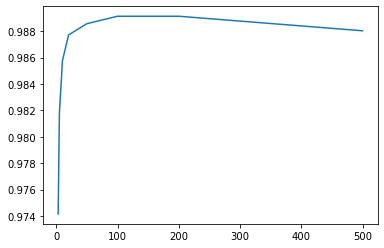

In [73]:
scores = []
N = [3,5,10,20,50,100,200,500]
for n in N:
    clf = BaggingClassifier(DecisionTreeClassifier(),max_features=0.5,max_samples=0.5,bootstrap=False,n_estimators=n)
    clf.fit(X_train, y_train)
    scores.append(f1_score(y_test, clf.predict(X_test),average="weighted"))

plt.plot(N,scores)
plt.show()

In [74]:
clf = BaggingClassifier(RandomForestClassifier(),max_features=0.5,max_samples=0.5,bootstrap=False,n_estimators=25)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print("BaggingClassifier")
print(classification_report(y_test, pred))

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['BaggingClassifier + Chart'] = clf.score(X_test, y_test)

BaggingClassifier
              precision    recall  f1-score   support

           1       0.96      0.99      0.98       494
           2       1.00      1.00      1.00       820
           3       1.00      1.00      1.00       964
           4       0.95      1.00      0.97       151
           5       1.00      0.69      0.82        13
           6       0.97      0.97      0.97       244
           7       1.00      0.98      0.99       130
           8       0.99      0.94      0.97       410
           9       1.00      0.99      0.99       361

    accuracy                           0.99      3587
   macro avg       0.98      0.95      0.96      3587
weighted avg       0.99      0.99      0.99      3587

Test prediction score:  0.9888022667995551
Test recall score:  0.9885698355171453
Test f1 score:  0.988569148485432
Test accuracy:  0.9885698355171453


I check how the Multi-layer Perceptron Classifier will deal with our data.

In [75]:
from sklearn.neural_network import MLPClassifier


In [76]:
cls_model = MLPClassifier(
    hidden_layer_sizes=(9,8, 4,3,4,2,9),
    activation='relu',
    solver='adam',
    random_state=42,
    max_iter=1000,
    batch_size=320)

cls_model.fit(X_train, y_train)

y_pred = cls_model.predict(X_test)
print(classification_report(y_test, y_pred))
Best_models['MLPClassifier'] = cls_model.score(X_test, y_test)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       494
           2       0.00      0.00      0.00       820
           3       0.27      1.00      0.42       964
           4       0.00      0.00      0.00       151
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00       244
           7       0.00      0.00      0.00       130
           8       0.00      0.00      0.00       410
           9       0.00      0.00      0.00       361

    accuracy                           0.27      3587
   macro avg       0.03      0.11      0.05      3587
weighted avg       0.07      0.27      0.11      3587



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
for hidden_layer_size in [3,5,10,15,25,50,100,200,300,500]:
#     rnd.seed(7)
    
    model = MLPClassifier(hidden_layer_size, activation="relu", max_iter=10000, alpha=0.001, tol=0.000001, batch_size=300)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_fitted = model.predict(X_train)
    

    print(hidden_layer_size, "Iter: ",model.n_iter_)
    preds = y_pred
    
    print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
    print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
    print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
    print("Test accuracy: ",accuracy_score(y_test, preds))

3 Iter:  29
Test prediction score:  0.16470443515204633
Test recall score:  0.30415388904376917
Test f1 score:  0.197968973365157
Test accuracy:  0.30415388904376917


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5 Iter:  356
Test prediction score:  0.07222562596135769
Test recall score:  0.2687482575968776
Test f1 score:  0.1138533598432828
Test accuracy:  0.2687482575968776


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10 Iter:  21
Test prediction score:  0.46683686897987
Test recall score:  0.5160301087259548
Test f1 score:  0.4823043704333745
Test accuracy:  0.5160301087259548


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15 Iter:  27
Test prediction score:  0.42675122549796246
Test recall score:  0.5085029272372457
Test f1 score:  0.4342691233439278
Test accuracy:  0.5085029272372457


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25 Iter:  29
Test prediction score:  0.5519295698541097
Test recall score:  0.49902425425146363
Test f1 score:  0.43220700154985664
Test accuracy:  0.49902425425146363


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50 Iter:  61
Test prediction score:  0.6732714975798615
Test recall score:  0.7170337329244494
Test f1 score:  0.6711481231784036
Test accuracy:  0.7170337329244494


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


100 Iter:  21
Test prediction score:  0.510980130408761
Test recall score:  0.6177864510733203
Test f1 score:  0.5265902134342197
Test accuracy:  0.6177864510733203


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200 Iter:  24
Test prediction score:  0.46541161515999996
Test recall score:  0.5447449121828827
Test f1 score:  0.4754833911715419
Test accuracy:  0.5447449121828827


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


300 Iter:  56
Test prediction score:  0.5581873925541994
Test recall score:  0.6342347365486479
Test f1 score:  0.5745714484877616
Test accuracy:  0.6342347365486479


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


500 Iter:  52
Test prediction score:  0.5560026900749823
Test recall score:  0.5896292166155562
Test f1 score:  0.5315368622411334
Test accuracy:  0.5896292166155562


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
import itertools

for h1, h2 in itertools.product([5,10,20],[5,10,20,]):
    
    
    model = MLPClassifier((h1,h2), activation="relu", max_iter=10000, alpha=0.0001, tol=0.0001, batch_size=300)
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test)
    y_fitted = model.predict(X_train)  
    
    print(h1, h2,"Iter: ",model.n_iter_)
    preds = y_pred
    print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
    print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
    print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
    print("Test accuracy: ",accuracy_score(y_test, preds))

5 5 Iter:  49
Test prediction score:  0.07222562596135769
Test recall score:  0.2687482575968776
Test f1 score:  0.1138533598432828
Test accuracy:  0.2687482575968776


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5 10 Iter:  30
Test prediction score:  0.052219349606116655
Test recall score:  0.2280457206579314
Test f1 score:  0.0849795459847779
Test accuracy:  0.2280457206579314


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5 20 Iter:  23
Test prediction score:  0.3036100413430794
Test recall score:  0.3058265960412601
Test f1 score:  0.1810882389703867
Test accuracy:  0.3058265960412601


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10 5 Iter:  171
Test prediction score:  0.07224576696134692
Test recall score:  0.2687482575968776
Test f1 score:  0.11387838255973186
Test accuracy:  0.2687482575968776


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10 10 Iter:  46
Test prediction score:  0.40513839303659055
Test recall score:  0.5023696682464455
Test f1 score:  0.39567374681308165
Test accuracy:  0.5023696682464455


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10 20 Iter:  47
Test prediction score:  0.5742650603643233
Test recall score:  0.5742960691385559
Test f1 score:  0.5439063069667939
Test accuracy:  0.5742960691385559


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20 5 Iter:  26
Test prediction score:  0.4580345873650195
Test recall score:  0.39420128240869806
Test f1 score:  0.308759507644466
Test accuracy:  0.39420128240869806


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20 10 Iter:  38
Test prediction score:  0.4801781904275045
Test recall score:  0.5090604962364093
Test f1 score:  0.4225845277341652
Test accuracy:  0.5090604962364093


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20 20 Iter:  43
Test prediction score:  0.1875420713273969
Test recall score:  0.30387510454418737
Test f1 score:  0.19127214820533767
Test accuracy:  0.30387510454418737


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
model = MLPClassifier(10, activation="relu", early_stopping=True, validation_fraction=0.2, n_iter_no_change=30, batch_size=300)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_fitted = model.predict(X_train)

print(h1, h2,"Iter: ",model.n_iter_)
preds = y_pred
print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))
Best_models['MLPClassifier + parameters'] = model.score(X_test, y_test)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\A

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\A

20 20 Iter:  72
Test prediction score:  0.740759215348319
Test recall score:  0.7340395873989406
Test f1 score:  0.7247639477445944
Test accuracy:  0.7340395873989406


D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The Sequential class was used to check the operation of the algorithm

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [81]:
model = Sequential()
model.add(Dense(10, activation="sigmoid", input_shape=(X_train.shape[1],)))
model.add(Dense(10, activation="sigmoid"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                690       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 811
Trainable params: 811
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(X_train, y_train, batch_size=160, epochs=100)

Epoch 1/100
46/46 [==============================] - 2s 2ms/step - loss: -3.0535 - accuracy: 0.1406
Epoch 2/100
46/46 [==============================] - 0s 1ms/step - loss: -9.3348 - accuracy: 0.1438
Epoch 3/100
46/46 [==============================] - 0s 1ms/step - loss: -14.8112 - accuracy: 0.1438
Epoch 4/100
46/46 [==============================] - 0s 1ms/step - loss: -20.9879 - accuracy: 0.1438
Epoch 5/100
46/46 [==============================] - 0s 1ms/step - loss: -26.8592 - accuracy: 0.1438
Epoch 6/100
46/46 [==============================] - 0s 1ms/step - loss: -32.3909 - accuracy: 0.1438
Epoch 7/100
46/46 [==============================] - 0s 1ms/step - loss: -38.5671 - accuracy: 0.1438
Epoch 8/100
46/46 [==============================] - 0s 1ms/step - loss: -46.3877 - accuracy: 0.1438
Epoch 9/100
46/46 [==============================] - 0s 1ms/step - loss: -55.9940 - accuracy: 0.1438
Epoch 10/100
46/46 [==============================] - 0s 1ms/step - loss: -67.3648 - accuracy

46/46 [==============================] - 0s 1ms/step - loss: -623.8417 - accuracy: 0.1438
Epoch 81/100
46/46 [==============================] - 0s 1ms/step - loss: -631.4036 - accuracy: 0.1438
Epoch 82/100
46/46 [==============================] - 0s 1ms/step - loss: -638.9801 - accuracy: 0.1438
Epoch 83/100
46/46 [==============================] - 0s 1ms/step - loss: -646.5560 - accuracy: 0.1438
Epoch 84/100
46/46 [==============================] - 0s 1ms/step - loss: -654.1107 - accuracy: 0.1438
Epoch 85/100
46/46 [==============================] - 0s 1ms/step - loss: -661.6757 - accuracy: 0.1438
Epoch 86/100
46/46 [==============================] - 0s 1ms/step - loss: -669.2441 - accuracy: 0.1438
Epoch 87/100
46/46 [==============================] - 0s 1ms/step - loss: -676.8226 - accuracy: 0.1438
Epoch 88/100
46/46 [==============================] - 0s 1ms/step - loss: -684.3945 - accuracy: 0.1438
Epoch 89/100
46/46 [==============================] - 0s 1ms/step - loss: -691.9462 - 

In [83]:
early_stopping = EarlyStopping(patience=3, monitor="val_loss")
model.fit(X_train, y_train, batch_size=16, callbacks=[early_stopping], validation_split=0.15, epochs=100)
preds = model.predict(X_test)

print("Test prediction score: ",precision_score(y_test, preds, average='weighted'))
print("Test recall score: ",recall_score(y_test, preds, average='weighted'))
print("Test f1 score: ",f1_score(y_test, preds, average='weighted'))
print("Test accuracy: ",accuracy_score(y_test, preds))

Best_models['Sequential + EarlyStopping'] = precision_score(y_test, preds, average='weighted')

Epoch 1/100
387/387 [==============================] - 1s 2ms/step - loss: -809.6395 - accuracy: 0.1412 - val_loss: -847.8364 - val_accuracy: 0.1583
Epoch 2/100
387/387 [==============================] - 0s 1ms/step - loss: -872.6736 - accuracy: 0.1412 - val_loss: -911.1607 - val_accuracy: 0.1583
Epoch 3/100
387/387 [==============================] - 0s 1ms/step - loss: -935.4677 - accuracy: 0.1412 - val_loss: -974.2831 - val_accuracy: 0.1583
Epoch 4/100
387/387 [==============================] - 0s 1ms/step - loss: -998.0437 - accuracy: 0.1412 - val_loss: -1037.2898 - val_accuracy: 0.1583
Epoch 5/100
387/387 [==============================] - 0s 1ms/step - loss: -1060.4761 - accuracy: 0.1412 - val_loss: -1100.2443 - val_accuracy: 0.1583
Epoch 6/100
387/387 [==============================] - 0s 1ms/step - loss: -1122.6937 - accuracy: 0.1412 - val_loss: -1162.7397 - val_accuracy: 0.1583
Epoch 7/100
387/387 [==============================] - 0s 1ms/step - loss: -1184.8906 - accuracy: 0.1

387/387 [==============================] - 0s 1ms/step - loss: -4167.5522 - accuracy: 0.1412 - val_loss: -4231.0747 - val_accuracy: 0.1583
Epoch 56/100
387/387 [==============================] - 0s 1ms/step - loss: -4229.7432 - accuracy: 0.1412 - val_loss: -4293.7998 - val_accuracy: 0.1583
Epoch 57/100
387/387 [==============================] - 0s 1ms/step - loss: -4291.9756 - accuracy: 0.1412 - val_loss: -4356.4883 - val_accuracy: 0.1583
Epoch 58/100
387/387 [==============================] - 0s 1ms/step - loss: -4354.1831 - accuracy: 0.1412 - val_loss: -4419.1597 - val_accuracy: 0.1583
Epoch 59/100
387/387 [==============================] - 0s 1ms/step - loss: -4416.3145 - accuracy: 0.1412 - val_loss: -4481.8130 - val_accuracy: 0.1583
Epoch 60/100
387/387 [==============================] - 0s 1ms/step - loss: -4478.4194 - accuracy: 0.1412 - val_loss: -4544.3423 - val_accuracy: 0.1583
Epoch 61/100
387/387 [==============================] - 0s 1ms/step - loss: -4540.5435 - accuracy: 0.

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Throughout the project, we added the results of individual models to the dictionary. It is presented as follows:



In [90]:
Best_models


{'DummyClassifier': 0.07222562596135769,
 'LogisticRegression': 0.6275439085586841,
 'LogisticRegression + StandardScaler': 0.9498187900752718,
 'RandomForestClassifier': 0.988848620016727,
 'DecisionTreeClassifier': 0.9687761360468358,
 'XGBClassifier': 0.988848620016727,
 'SVC': 0.5054362977418455,
 'SVC + StandardScaler': 0.5054362977418455,
 'RandomForestClassifier + GridSearchCV': 0.9838304990242542,
 'RandomForestRegressor + RandomizedSearchCV': 0.9891274045163089,
 'RandomForestClassifier + GridSearchCV + RandomizedSearchCV': 0.9899637580150543,
 'RandomForestClassifier + RandomUnderSampler': 0.9311402286032897,
 'XGBClassifier + RandomUnderSampler': 0.9185949261221076,
 'RandomForestClassifier + RandomUnderSampler - not majority': 0.9342068580986898,
 'XGBClassifier + RandomUnderSampler - not majority': 0.9311402286032897,
 'RandomForestClassifier + TomekLinks': 0.9880122665179816,
 'XGBClassifier + TomekLinks': 0.9860607750209088,
 'RandomForestClassifier + TomekLinks - auto':

In [91]:
print(sorted(Best_models.items(), key=lambda x: x[1]))

[('Sequential + EarlyStopping', 0.018966672467228832), ('DummyClassifier', 0.07222562596135769), ('MLPClassifier', 0.2687482575968776), ('SVC', 0.5054362977418455), ('SVC + StandardScaler', 0.5054362977418455), ('LogisticRegression', 0.6275439085586841), ('MLPClassifier + parameters', 0.7340395873989406), ('XGBClassifier + RandomUnderSampler', 0.9185949261221076), ('RandomForestClassifier + RandomUnderSampler', 0.9311402286032897), ('XGBClassifier + RandomUnderSampler - not majority', 0.9311402286032897), ('RandomForestClassifier + RandomUnderSampler - not majority', 0.9342068580986898), ('LogisticRegression + StandardScaler', 0.9498187900752718), ('DecisionTreeClassifier', 0.9687761360468358), ('RandomForestClassifier + GridSearchCV', 0.9838304990242542), ('XGBClassifier + TomekLinks - auto', 0.985781990521327), ('XGBClassifier + TomekLinks', 0.9860607750209088), ('BaggingClassifier + Chart', 0.9868971285196543), ('RandomForestClassifier + SMOTETomek', 0.9877334820183997), ('XGBClassi

The best model turned out to be: "RandomForestClassifier + GridSearchCV + RandomizedSearchCV"

Of course, it must be noted that the parameters for the model were selected using: GridSearchCV with RandomizedSearchCV

He has achieved:

Test prediction score:  0.9902065570838595

Test recall score:  0.9899637580150543

Test f1 score:  0.9899729667008317

Test accuracy:  0.9899637580150543

With these parameters: 
RandomForestClassifier (bootstrap = False, max_depth = 30, max_features = 2, min_samples_leaf = 1, 
                                  min_samples_split=2, n_estimators = 1450)                                